In [1]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# Data

In [3]:
START = '2007-01-01'
END = '2024-04-15'

In [4]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
cond3 = stk_info['transCurrCD']=='CNY'
stk_info = stk_info[cond1 & cond2 & cond3].copy()
stk_id = stk_info['secID']

In [5]:
stk_id.nunique()

5359

## ST

In [6]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Risk free rate

In [7]:
shibor_df = DataAPI.MktIborGet(secID="Shibor1M.IRCN",beginDate=START,endDate=END,field=['secID','tradeDate','rate'],pandas="1")
shibor_df['rate'] = shibor_df['rate']*0.01/12
shibor_df['tradeDate'] = pd.to_datetime(shibor_df['tradeDate'])
shibor_df.drop('secID',axis=1,inplace=True)
shibor_df.rename(columns={'rate':'rf'},inplace=True)
shibor_df['ym'] = shibor_df['tradeDate'].dt.to_period('M')
shibor_df.sort_values('tradeDate',inplace=True)
shibor_df_m = shibor_df.groupby('ym',as_index=False).last()
shibor_df_m.drop('tradeDate',axis=1,inplace=True)
shibor_df_m

ym        rf
0    2007-01  0.002100
1    2007-02  0.002110
2    2007-03  0.002234
3    2007-04  0.002125
4    2007-05  0.002527
5    2007-06  0.002542
6    2007-07  0.002481
7    2007-08  0.002404
..       ...       ...
200  2023-09  0.001904
201  2023-10  0.001890
202  2023-11  0.001914
203  2023-12  0.002068
204  2024-01  0.001902
205  2024-02  0.001749
206  2024-03  0.001783
207  2024-04  0.001687

[208 rows x 2 columns]

## Beta

In [8]:
beta_df = pd.read_pickle('./data/beta_df.pkl')
beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")
beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')
beta_df.drop(['Beta60','Beta120'],axis=1,inplace=True)
beta_df['Beta252'] = pd.to_numeric(beta_df['Beta252'])
# Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta252_winsor'] = beta_df['Beta252'].clip(lower=beta_df['Beta252'].quantile(lower_q),upper=beta_df['Beta252'].quantile(up_q))
# Monthly
beta_df_m = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()
beta_df_m.rename(columns={'Beta252':'beta'},inplace=True)
beta_df_m

secID       ym    beta
0       000001.XSHE  2007-01  0.7949
1       000001.XSHE  2007-02  0.7880
2       000001.XSHE  2007-03  0.8512
3       000001.XSHE  2007-04  0.8642
4       000001.XSHE  2007-05  0.7715
5       000001.XSHE  2007-06  0.4614
6       000001.XSHE  2007-07  0.6423
7       000001.XSHE  2007-08  0.7722
...             ...      ...     ...
619996  689009.XSHG  2023-08  0.8234
619997  689009.XSHG  2023-09  0.9152
619998  689009.XSHG  2023-10  0.9247
619999  689009.XSHG  2023-11  0.9541
620000  689009.XSHG  2023-12  1.0448
620001  689009.XSHG  2024-01  1.2314
620002  689009.XSHG  2024-02  1.4905
620003  689009.XSHG  2024-03  1.5477

[620004 rows x 3 columns]

## BM

In [9]:
pb_df = pd.read_pickle('./data/pb_df.pkl')
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])
pb_df['PB'] = pd.to_numeric(pb_df['PB'])
pb_df['ym'] = pb_df['tradeDate'].dt.to_period('M')
pb_df.sort_values(['secID','tradeDate'],inplace=True)
pb_df = pb_df.groupby(['secID','ym'],as_index=False).last()
pb_df['bm'] = 1 / pb_df['PB']
pb_df.drop(['tradeDate','PB'],axis=1,inplace=True)
pb_df = pb_df[pb_df['bm'] >= 0]
pb_df

secID       ym        bm
0       000001.XSHE  2007-01  0.162639
1       000001.XSHE  2007-02  0.163321
2       000001.XSHE  2007-03  0.176236
3       000001.XSHE  2007-04  0.140732
4       000001.XSHE  2007-05  0.127291
5       000001.XSHE  2007-06  0.123739
6       000001.XSHE  2007-07  0.093992
7       000001.XSHE  2007-08  0.097085
...             ...      ...       ...
625109  689009.XSHG  2023-09  0.209367
625110  689009.XSHG  2023-10  0.223899
625111  689009.XSHG  2023-11  0.221803
625112  689009.XSHG  2023-12  0.247525
625113  689009.XSHG  2024-01  0.313607
625114  689009.XSHG  2024-02  0.241569
625115  689009.XSHG  2024-03  0.247127
625116  689009.XSHG  2024-04  0.260342

[617335 rows x 3 columns]

## Trading data

In [10]:
# %%time
# # About 10 mins
# # # 从优矿下载股票信息，时间较长。由于优矿的限制，每次下载3年的数据

# stk_dict = {}
# begin_ = dt.datetime.strptime(START, '%Y-%m-%d').year
# end_ = dt.datetime.strptime(START, '%Y-%m-%d').year+3
# field = ['secID','tradeDate','preClosePrice','closePrice','negMarketValue','turnoverValue','turnoverRate']
# while begin_ <= 2024:
#     if begin_ == 2024:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=field,pandas="1")
#     else:
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=field,pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(stk_dict)):
#     stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=field)
    
# stk_df.to_pickle('./data/stk_df.pkl')

In [11]:
# stk_df = pd.read_pickle('./data/stk_df.pkl')
# stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
# stk_df.sort_values(['secID','tradeDate'],inplace=True)
# # drop ST stocks
# print(stk_df.shape)
# stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
# stk_df = stk_df[stk_df['STflg'].isna()].copy()
# stk_df.drop('STflg',axis=1,inplace=True)
# print(stk_df.shape)

In [12]:
# num_cols = ['preClosePrice','closePrice','negMarketValue','turnoverValue','turnoverRate']
# for col in num_cols:
#     stk_df[col] = pd.to_numeric(stk_df[col])

In [13]:
# stk_df.info()

In [14]:
# # # If the trading days are required to be consecutive, fill missing days first. This could possibly produce a much larger df when using 
# ## daily data, and if the missing dates are a lot for some securities

# def fill_missing(df, full_dates, id_col='secID', date_col='tradeDate'):
#     """
#     This function fills the missing dates for stocks.
#     Parameters:
#         df: The dataframe. Could be a sub-dataframe created by "groupby".
#             The dataframe must be sorted on the "date_col".
#         full_dates: the unique dates covering all securities in the full dataframe. 
#                     Need to be sorted.
#         id_col: the security id.
#         date_col: the dates column for the security
#     Returns:
#         A dataframe with the missing dates filled with NA.
#     """
#     stk_id = df[id_col].unique()
#     # Newer version of pandas will allow comparison between "Timestamp" and "datetime64"
# #     date_start = np.where(full_dates == df[date_col].min())[0][0] 
# #     date_end = np.where(full_dates == df[date_col].max())[0][0]
#     date_start = np.where(full_dates == df[date_col].min().to_datetime64())[0][0] 
#     date_end = np.where(full_dates == df[date_col].max().to_datetime64())[0][0]
#     dates = full_dates[date_start:date_end+1]
#     idx = pd.MultiIndex.from_product([stk_id,dates],
#                                      names=(id_col,date_col))
#     df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
#     return df

# full_dates = np.sort(stk_df['tradeDate'].unique())

# full_dates

In [15]:
# %%time
# stk_df = stk_df.groupby('secID').apply(fill_missing, full_dates=full_dates)
# # About 1min

## Amihud (2002) liquidity

Amihud (2002)'s liquidity measure is perhaps the most widely known.

$$ illiq_i = \frac{1}{D} \sum^D_{d=1} \frac{|R_{i,d}|}{VOLD_{i,d}} $$

VOLD: the dollar volume, measured as "close_price * shares_traded"

Intuition: the effect of volume on moving prices. If a small volume moves price significantly (nonsignificantly), the stock is quite illiquid (liquid).

Period choices: Amihud(2002) uses t-11 month through t month (12 months) daily data as the measure for month t. 

Let's use the two measures: 
- Amihud's original measure, but we do not stick to calendar month. Let's use 250 trading days.
- a simple one: one-month daily data.

Also, let's use the actual dollar volume within one day

- Acharya and Pedersen (2005): liquidity should be positively correlated with contemporaneous returns, and negatively with future returns
- 其他相关文献， Bali, Peng, Shen, and Tang (2014)，Chordia, Roll and Subrahmanyam (2000)
- Pastor and Stambaugh (2003): Aggregate liquidity factor.

In [16]:
# stk_df

In [17]:
# stk_df.reset_index(drop=True, inplace=True)

# stk_df['ret_daily'] = stk_df['closePrice'] / stk_df['preClosePrice'] - 1
# stk_df['illiq_daily'] = abs(stk_df['ret_daily'].values) / stk_df['turnoverValue'].values
# stk_df.loc[np.isinf(stk_df['illiq_daily']),'illiq_daily'] = np.nan
# stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')

# stk_df.to_pickle('./data/stk_df_filled.pkl')

In [18]:
stk_df = pd.read_pickle('./data/stk_df_filled.pkl')

In [19]:
stk_df.loc[np.isinf(stk_df['illiq_daily'])]

Empty DataFrame
Columns: [secID, tradeDate, preClosePrice, closePrice, negMarketValue, turnoverValue, turnoverRate, ret_daily, illiq_daily, ym]
Index: []

In [20]:
stk_df[(stk_df['secID']=='000001.XSHE') & (stk_df['tradeDate']>='2010-06-01') & (stk_df['tradeDate']<='2010-09-05')]

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
722  000001.XSHE 2010-06-01        722.475     713.810    5.058718e+10   
723  000001.XSHE 2010-06-02        713.810     710.922    5.038249e+10   
724  000001.XSHE 2010-06-03        710.922     710.509    5.035325e+10   
725  000001.XSHE 2010-06-04        710.509     713.810    5.058718e+10   
726  000001.XSHE 2010-06-07        713.810     697.718    4.944677e+10   
727  000001.XSHE 2010-06-08        697.718     689.054    4.883271e+10   
728  000001.XSHE 2010-06-09        689.054     729.077    5.166910e+10   
729  000001.XSHE 2010-06-10        729.077     705.971    5.003160e+10   
..           ...        ...            ...         ...             ...   
780  000001.XSHE 2010-08-25        722.475     722.475    5.437499e+10   
781  000001.XSHE 2010-08-26        722.475     722.475    5.437499e+10   
782  000001.XSHE 2010-08-27        722.475     722.475    5.437499e+10   
783  000001.XSHE 2010-08-30        722.475     722.475    5.437499e+10   
784  000001.XSHE 2010-08-31        722.475     722.475    5.437499e+10   
785  000001.XSHE 2010-09-01        722.475     722.475    5.437499e+10   
786  000001.XSHE 2010-09-02        722.475     750.532    5.648664e+10   
787  000001.XSHE 2010-09-03        750.532     732.790    5.515133e+10   

     turnoverValue  turnoverRate  ret_daily   illiq_daily       ym  
722   3.790589e+08        0.0075  -0.011993  3.164019e-11  2010-06  
723   4.307207e+08        0.0086  -0.004046  9.393313e-12  2010-06  
724   5.011432e+08        0.0098  -0.000581  1.159221e-12  2010-06  
725   2.328248e+08        0.0046   0.004646  1.995477e-11  2010-06  
726   4.105509e+08        0.0083  -0.022544  5.491113e-11  2010-06  
727   2.861562e+08        0.0058  -0.012418  4.339457e-11  2010-06  
728   8.579786e+08        0.0170   0.058084  6.769864e-11  2010-06  
729   4.895630e+08        0.0097  -0.031692  6.473554e-11  2010-06  
..             ...           ...        ...           ...      ...  
780   0.000000e+00        0.0000   0.000000           NaN  2010-08  
781   0.000000e+00        0.0000   0.000000           NaN  2010-08  
782   0.000000e+00        0.0000   0.000000           NaN  2010-08  
783   0.000000e+00        0.0000   0.000000           NaN  2010-08  
784   0.000000e+00        0.0000   0.000000           NaN  2010-08  
785   0.000000e+00        0.0000   0.000000           NaN  2010-09  
786   2.984709e+09        0.0526   0.038835  1.301117e-11  2010-09  
787   1.110874e+09        0.0201  -0.023639  2.127986e-11  2010-09  

[66 rows x 10 columns]

### Monthly trading data

In [21]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).last()
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)
stk_df_m['size'] = np.log(stk_df_m['negMarketValue'])
stk_df_m.drop(['preClosePrice'],axis=1,inplace=True)
stk_df_m = pd.merge(stk_df_m, shibor_df_m, on='ym')
stk_df_m['exret'] = stk_df_m['ret'] - stk_df_m['rf']
stk_df_m.sort_values(['secID','ym'],inplace=True)
stk_df_m.rename(columns={'negMarketValue':'mktcap'},inplace=True)
stk_df_m

secID       ym  tradeDate  closePrice        mktcap  \
0       000001.XSHE  2007-06 2007-06-29     870.870  4.266117e+10   
1293    000001.XSHE  2007-07 2007-07-31    1146.498  5.616330e+10   
2595    000001.XSHE  2007-08 2007-08-31    1202.510  5.890714e+10   
3922    000001.XSHE  2007-09 2007-09-28    1265.167  6.197651e+10   
5264    000001.XSHE  2007-10 2007-10-31    1520.542  7.448652e+10   
6612    000001.XSHE  2007-11 2007-11-30    1141.751  5.593078e+10   
7976    000001.XSHE  2007-12 2007-12-28    1221.497  6.574629e+10   
9362    000001.XSHE  2008-01 2008-01-31    1053.778  5.850212e+10   
...             ...      ...        ...         ...           ...   
575773  689009.XSHG  2023-09 2023-09-28      34.830  1.785208e+10   
580846  689009.XSHG  2023-10 2023-10-31      32.790  1.716478e+10   
585927  689009.XSHG  2023-11 2023-11-30      33.100  1.732706e+10   
591023  689009.XSHG  2023-12 2023-12-29      29.660  1.552630e+10   
596129  689009.XSHG  2024-01 2024-01-31      23.340  1.221793e+10   
601238  689009.XSHG  2024-02 2024-02-29      30.300  1.586132e+10   
606353  689009.XSHG  2024-03 2024-03-29      29.950  1.543851e+10   
611468  689009.XSHG  2024-04 2024-04-12      27.800  1.433023e+10   

        turnoverValue  turnoverRate  ret_daily   illiq_daily       ret  \
0        1.410758e+09        0.0316  -0.086928  6.161781e-11       NaN   
1293     1.479466e+09        0.0270   0.059356  4.012016e-11  0.316497   
2595     6.552881e+08        0.0112   0.007958  1.214425e-11  0.048855   
3922     1.408136e+09        0.0228   0.030147  2.140927e-11  0.052105   
5264     1.440425e+09        0.0200   0.065410  4.541049e-11  0.201851   
6612     5.452159e+08        0.0096  -0.026181  4.801976e-11 -0.249116   
7976     1.019671e+09        0.0154  -0.010256  1.005854e-11  0.069845   
9362     5.328429e+08        0.0089  -0.019146  3.593101e-11 -0.137306   
...               ...           ...        ...           ...       ...   
575773   8.745210e+07        0.0049   0.003746  4.283943e-11  0.042502   
580846   6.562302e+07        0.0038  -0.006364  9.697263e-11 -0.058570   
585927   1.497706e+08        0.0087  -0.005110  3.411690e-11  0.009454   
591023   1.169338e+08        0.0075   0.015753  1.347209e-10 -0.103927   
596129   1.255953e+08        0.0100  -0.033940  2.702363e-10 -0.213082   
601238   2.444204e+08        0.0156   0.044828  1.834036e-10  0.298201   
606353   1.180638e+08        0.0077  -0.000334  2.827102e-12 -0.011551   
611468   1.743296e+08        0.0121   0.017197  9.864775e-11 -0.071786   

             size        rf     exret  
0       24.476555  0.002542       NaN  
1293    24.751529  0.002481  0.314016  
2595    24.799228  0.002404  0.046451  
3922    24.850021  0.002621  0.049484  
5264    25.033884  0.003095  0.198756  
6612    24.747381  0.003780 -0.252896  
7976    24.909069  0.003011  0.066834  
9362    24.792329  0.002949 -0.140255  
...           ...       ...       ...  
575773  23.605386  0.001904  0.040598  
580846  23.566125  0.001890 -0.060460  
585927  23.575535  0.001914  0.007540  
591023  23.465801  0.002068 -0.105996  
596129  23.226170  0.001902 -0.214983  
601238  23.487149  0.001749  0.296451  
606353  23.460131  0.001783 -0.013334  
611468  23.385637  0.001687 -0.073474  

[617652 rows x 13 columns]

### Momentum and reversal

#### Using unfilled data 

In [22]:
stk_unfilled_df = pd.read_pickle('./data/stk_df.pkl')
stk_unfilled_df['tradeDate'] = pd.to_datetime(stk_unfilled_df['tradeDate'], format='%Y-%m-%d')
stk_unfilled_df['ym'] = stk_unfilled_df['tradeDate'].dt.to_period('M')
stk_unfilled_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_unfilled_df.shape)
stk_unfilled_df = pd.merge(stk_unfilled_df, st_df, on=['secID','tradeDate'],how='left')
stk_unfilled_df = stk_unfilled_df[stk_unfilled_df['STflg'].isna()].copy()
stk_unfilled_df.drop('STflg',axis=1,inplace=True)
print(stk_unfilled_df.shape)
# Monthly
stk_unfilled_df_m = stk_unfilled_df.groupby(['secID','ym'],as_index=False).last()

(12553162, 8)
(12001762, 8)


In [23]:
stk_unfilled_df_m['ret_mom'] = stk_unfilled_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1) #这个ret_mom不用作后面ret的计算，后面仍保留monthly ret
stk_unfilled_df_m.sort_values(['secID','ym'],inplace=True)

In [24]:
stk_unfilled_df_m['1+ret_mom'] = stk_unfilled_df_m['ret_mom'] + 1

In [25]:
stk_unfilled_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2007-06 2007-06-29        953.780     870.870   
1       000001.XSHE  2007-07 2007-07-31       1082.259    1146.498   
2       000001.XSHE  2007-08 2007-08-31       1193.016    1202.510   
3       000001.XSHE  2007-09 2007-09-28       1228.142    1265.167   
4       000001.XSHE  2007-10 2007-10-31       1427.189    1520.542   
5       000001.XSHE  2007-11 2007-11-30       1172.447    1141.751   
6       000001.XSHE  2007-12 2007-12-28       1234.155    1221.497   
7       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
...             ...      ...        ...            ...         ...   
598692  689009.XSHG  2023-09 2023-09-28         34.700      34.830   
598693  689009.XSHG  2023-10 2023-10-31         33.000      32.790   
598694  689009.XSHG  2023-11 2023-11-30         33.270      33.100   
598695  689009.XSHG  2023-12 2023-12-29         29.200      29.660   
598696  689009.XSHG  2024-01 2024-01-31         24.160      23.340   
598697  689009.XSHG  2024-02 2024-02-29         29.000      30.300   
598698  689009.XSHG  2024-03 2024-03-29         29.960      29.950   
598699  689009.XSHG  2024-04 2024-04-12         27.330      27.800   

        negMarketValue  turnoverValue  turnoverRate   ret_mom  1+ret_mom  
0         4.266117e+10   1.410758e+09        0.0316       NaN        NaN  
1         5.616330e+10   1.479466e+09        0.0270  0.316497   1.316497  
2         5.890714e+10   6.552881e+08        0.0112  0.048855   1.048855  
3         6.197651e+10   1.408136e+09        0.0228  0.052105   1.052105  
4         7.448652e+10   1.440425e+09        0.0200  0.201851   1.201851  
5         5.593078e+10   5.452159e+08        0.0096 -0.249116   0.750884  
6         6.574629e+10   1.019671e+09        0.0154  0.069845   1.069845  
7         5.850212e+10   5.328429e+08        0.0089 -0.137306   0.862694  
...                ...            ...           ...       ...        ...  
598692    1.785208e+10   8.745210e+07        0.0049  0.042502   1.042502  
598693    1.716478e+10   6.562302e+07        0.0038 -0.058570   0.941430  
598694    1.732706e+10   1.497706e+08        0.0087  0.009454   1.009454  
598695    1.552630e+10   1.169338e+08        0.0075 -0.103927   0.896073  
598696    1.221793e+10   1.255953e+08        0.0100 -0.213082   0.786918  
598697    1.586132e+10   2.444204e+08        0.0156  0.298201   1.298201  
598698    1.543851e+10   1.180638e+08        0.0077 -0.011551   0.988449  
598699    1.433023e+10   1.743296e+08        0.0121 -0.071786   0.928214  

[598700 rows x 10 columns]

In [26]:
stk_unfilled_df_m['mom'] = stk_unfilled_df_m.groupby('secID').rolling(11,min_periods=9)['1+ret_mom'].apply(np.prod, raw=True).values - 1

In [27]:
stk_unfilled_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2007-06 2007-06-29        953.780     870.870   
1       000001.XSHE  2007-07 2007-07-31       1082.259    1146.498   
2       000001.XSHE  2007-08 2007-08-31       1193.016    1202.510   
3       000001.XSHE  2007-09 2007-09-28       1228.142    1265.167   
4       000001.XSHE  2007-10 2007-10-31       1427.189    1520.542   
5       000001.XSHE  2007-11 2007-11-30       1172.447    1141.751   
6       000001.XSHE  2007-12 2007-12-28       1234.155    1221.497   
7       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
...             ...      ...        ...            ...         ...   
598692  689009.XSHG  2023-09 2023-09-28         34.700      34.830   
598693  689009.XSHG  2023-10 2023-10-31         33.000      32.790   
598694  689009.XSHG  2023-11 2023-11-30         33.270      33.100   
598695  689009.XSHG  2023-12 2023-12-29         29.200      29.660   
598696  689009.XSHG  2024-01 2024-01-31         24.160      23.340   
598697  689009.XSHG  2024-02 2024-02-29         29.000      30.300   
598698  689009.XSHG  2024-03 2024-03-29         29.960      29.950   
598699  689009.XSHG  2024-04 2024-04-12         27.330      27.800   

        negMarketValue  turnoverValue  turnoverRate   ret_mom  1+ret_mom  \
0         4.266117e+10   1.410758e+09        0.0316       NaN        NaN   
1         5.616330e+10   1.479466e+09        0.0270  0.316497   1.316497   
2         5.890714e+10   6.552881e+08        0.0112  0.048855   1.048855   
3         6.197651e+10   1.408136e+09        0.0228  0.052105   1.052105   
4         7.448652e+10   1.440425e+09        0.0200  0.201851   1.201851   
5         5.593078e+10   5.452159e+08        0.0096 -0.249116   0.750884   
6         6.574629e+10   1.019671e+09        0.0154  0.069845   1.069845   
7         5.850212e+10   5.328429e+08        0.0089 -0.137306   0.862694   
...                ...            ...           ...       ...        ...   
598692    1.785208e+10   8.745210e+07        0.0049  0.042502   1.042502   
598693    1.716478e+10   6.562302e+07        0.0038 -0.058570   0.941430   
598694    1.732706e+10   1.497706e+08        0.0087  0.009454   1.009454   
598695    1.552630e+10   1.169338e+08        0.0075 -0.103927   0.896073   
598696    1.221793e+10   1.255953e+08        0.0100 -0.213082   0.786918   
598697    1.586132e+10   2.444204e+08        0.0156  0.298201   1.298201   
598698    1.543851e+10   1.180638e+08        0.0077 -0.011551   0.988449   
598699    1.433023e+10   1.743296e+08        0.0121 -0.071786   0.928214   

             mom  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
5            NaN  
6            NaN  
7            NaN  
...          ...  
598692  0.088437  
598693 -0.017675  
598694  0.085602  
598695 -0.106357  
598696 -0.292727  
598697 -0.195005  
598698 -0.104366  
598699 -0.149327  

[598700 rows x 11 columns]

In [28]:
stk_df_m = pd.merge(stk_df_m, stk_unfilled_df_m[['secID','ym','1+ret_mom']],on=['secID','ym'],how='left')

In [29]:
stk_df_m[(stk_df_m['secID']=='000001.XSHE') & (stk_df_m['ym']>='2010-06') & (stk_df_m['ym']<='2010-10')]

secID       ym  tradeDate  closePrice        mktcap  turnoverValue  \
36  000001.XSHE  2010-06 2010-06-30     722.475  5.437499e+10            0.0   
37  000001.XSHE  2010-07 2010-07-30     722.475  5.437499e+10            0.0   
38  000001.XSHE  2010-08 2010-08-31     722.475  5.437499e+10            0.0   
39  000001.XSHE  2010-09 2010-09-30     669.249  5.036906e+10            0.0   
40  000001.XSHE  2010-10 2010-10-29     759.610  5.716982e+10    663509380.0   

    turnoverRate  ret_daily   illiq_daily       ret       size        rf  \
36        0.0000   0.000000  9.651729e-11  0.000000  24.719170  0.003236   
37        0.0000   0.000000           NaN  0.000000  24.719170  0.001798   
38        0.0000   0.000000           NaN  0.000000  24.719170  0.002369   
39        0.0000   0.000000  7.082247e-12 -0.073672  24.642643  0.002922   
40        0.0115  -0.019178  2.890457e-11  0.135019  24.769292  0.002214   

       exret  1+ret_mom  
36 -0.003236   1.000000  
37 -0.001798   1.000000  
38 -0.002369   1.000000  
39 -0.076594   0.926328  
40  0.132805   1.135019

In [30]:
stk_df_m[(stk_df_m['secID']=='000007.XSHE')&(stk_df_m['ym']>='2021-02')]

secID       ym  tradeDate  closePrice        mktcap  \
1134  000007.XSHE  2021-02 2021-02-26      48.845  1.254329e+09   
1135  000007.XSHE  2021-03 2021-03-31      46.559  1.195629e+09   
1136  000007.XSHE  2021-04 2021-04-30      47.401  1.217255e+09   
1137  000007.XSHE  2021-05 2021-05-31         NaN           NaN   
1138  000007.XSHE  2021-06 2021-06-30         NaN           NaN   
1139  000007.XSHE  2021-07 2021-07-30         NaN           NaN   
1140  000007.XSHE  2021-08 2021-08-31         NaN           NaN   
1141  000007.XSHE  2021-09 2021-09-30         NaN           NaN   
...           ...      ...        ...         ...           ...   
1165  000007.XSHE  2023-09 2023-09-28      54.138  1.390266e+09   
1166  000007.XSHE  2023-10 2023-10-31      60.394  1.550919e+09   
1167  000007.XSHE  2023-11 2023-11-30      61.718  1.584903e+09   
1168  000007.XSHE  2023-12 2023-12-29      58.590  1.504577e+09   
1169  000007.XSHE  2024-01 2024-01-31      53.777  1.380998e+09   
1170  000007.XSHE  2024-02 2024-02-29      47.882  1.229613e+09   
1171  000007.XSHE  2024-03 2024-03-29      53.777  1.380998e+09   
1172  000007.XSHE  2024-04 2024-04-12      53.296  1.368640e+09   

      turnoverValue  turnoverRate  ret_daily   illiq_daily       ret  \
1134   2.533973e+08        0.2129   0.100286  3.957662e-10  0.537892   
1135   1.236837e+08        0.1049   0.099438  8.039699e-10 -0.046801   
1136   0.000000e+00        0.0000   0.000000  4.929238e-10  0.018085   
1137            NaN           NaN        NaN           NaN       NaN   
1138            NaN           NaN        NaN           NaN       NaN   
1139            NaN           NaN        NaN           NaN       NaN   
1140            NaN           NaN        NaN           NaN       NaN   
1141            NaN           NaN        NaN           NaN       NaN   
...             ...           ...        ...           ...       ...   
1165   6.191987e+06        0.0045  -0.002230  3.601501e-10 -0.114176   
1166   1.325383e+07        0.0086   0.028683  2.164156e-09  0.115557   
1167   2.307914e+07        0.0146   0.049091  2.127055e-09  0.021923   
1168   3.560853e+06        0.0024   0.000000  0.000000e+00 -0.050682   
1169   1.271714e+07        0.0091  -0.050966  4.007679e-09 -0.082147   
1170   1.621341e+07        0.0134  -0.005008  3.088801e-10 -0.109619   
1171   7.505215e+06        0.0055  -0.006668  8.884681e-10  0.123115   
1172   4.777189e+06        0.0035   0.004524  9.469004e-10 -0.008944   

           size        rf     exret  1+ret_mom  
1134  20.949867  0.002266  0.535627   1.537892  
1135  20.901938  0.002118 -0.048919   0.953199  
1136  20.919864  0.002074  0.016010   1.018085  
1137        NaN  0.002006       NaN        NaN  
1138        NaN  0.002012       NaN        NaN  
1139        NaN  0.001942       NaN        NaN  
1140        NaN  0.001941       NaN        NaN  
1141        NaN  0.002033       NaN        NaN  
...         ...       ...       ...        ...  
1165  21.052761  0.001904 -0.116080        NaN  
1166  21.162113  0.001890  0.113667        NaN  
1167  21.183789  0.001914  0.020009        NaN  
1168  21.131777  0.002068 -0.052750        NaN  
1169  21.046072  0.001902 -0.084049        NaN  
1170  20.929965  0.001749 -0.111369        NaN  
1171  21.046072  0.001783  0.121332        NaN  
1172  21.037083  0.001687 -0.010632        NaN  

[39 rows x 14 columns]

In [31]:
stk_df_m.loc[stk_df_m['1+ret_mom'].isna(),'1+ret_mom'] = 1 # 缺失位置填充为1，以便连乘。

In [32]:
stk_df_m['mom'] = stk_df_m.groupby('secID').rolling(11,min_periods=11)['1+ret_mom'].apply(np.prod, raw=True).values - 1 

In [33]:
stk_df_m

secID       ym  tradeDate  closePrice        mktcap  \
0       000001.XSHE  2007-06 2007-06-29     870.870  4.266117e+10   
1       000001.XSHE  2007-07 2007-07-31    1146.498  5.616330e+10   
2       000001.XSHE  2007-08 2007-08-31    1202.510  5.890714e+10   
3       000001.XSHE  2007-09 2007-09-28    1265.167  6.197651e+10   
4       000001.XSHE  2007-10 2007-10-31    1520.542  7.448652e+10   
5       000001.XSHE  2007-11 2007-11-30    1141.751  5.593078e+10   
6       000001.XSHE  2007-12 2007-12-28    1221.497  6.574629e+10   
7       000001.XSHE  2008-01 2008-01-31    1053.778  5.850212e+10   
...             ...      ...        ...         ...           ...   
617644  689009.XSHG  2023-09 2023-09-28      34.830  1.785208e+10   
617645  689009.XSHG  2023-10 2023-10-31      32.790  1.716478e+10   
617646  689009.XSHG  2023-11 2023-11-30      33.100  1.732706e+10   
617647  689009.XSHG  2023-12 2023-12-29      29.660  1.552630e+10   
617648  689009.XSHG  2024-01 2024-01-31      23.340  1.221793e+10   
617649  689009.XSHG  2024-02 2024-02-29      30.300  1.586132e+10   
617650  689009.XSHG  2024-03 2024-03-29      29.950  1.543851e+10   
617651  689009.XSHG  2024-04 2024-04-12      27.800  1.433023e+10   

        turnoverValue  turnoverRate  ret_daily   illiq_daily       ret  \
0        1.410758e+09        0.0316  -0.086928  6.161781e-11       NaN   
1        1.479466e+09        0.0270   0.059356  4.012016e-11  0.316497   
2        6.552881e+08        0.0112   0.007958  1.214425e-11  0.048855   
3        1.408136e+09        0.0228   0.030147  2.140927e-11  0.052105   
4        1.440425e+09        0.0200   0.065410  4.541049e-11  0.201851   
5        5.452159e+08        0.0096  -0.026181  4.801976e-11 -0.249116   
6        1.019671e+09        0.0154  -0.010256  1.005854e-11  0.069845   
7        5.328429e+08        0.0089  -0.019146  3.593101e-11 -0.137306   
...               ...           ...        ...           ...       ...   
617644   8.745210e+07        0.0049   0.003746  4.283943e-11  0.042502   
617645   6.562302e+07        0.0038  -0.006364  9.697263e-11 -0.058570   
617646   1.497706e+08        0.0087  -0.005110  3.411690e-11  0.009454   
617647   1.169338e+08        0.0075   0.015753  1.347209e-10 -0.103927   
617648   1.255953e+08        0.0100  -0.033940  2.702363e-10 -0.213082   
617649   2.444204e+08        0.0156   0.044828  1.834036e-10  0.298201   
617650   1.180638e+08        0.0077  -0.000334  2.827102e-12 -0.011551   
617651   1.743296e+08        0.0121   0.017197  9.864775e-11 -0.071786   

             size        rf     exret  1+ret_mom       mom  
0       24.476555  0.002542       NaN   1.000000       NaN  
1       24.751529  0.002481  0.314016   1.316497       NaN  
2       24.799228  0.002404  0.046451   1.048855       NaN  
3       24.850021  0.002621  0.049484   1.052105       NaN  
4       25.033884  0.003095  0.198756   1.201851       NaN  
5       24.747381  0.003780 -0.252896   0.750884       NaN  
6       24.909069  0.003011  0.066834   1.069845       NaN  
7       24.792329  0.002949 -0.140255   0.862694       NaN  
...           ...       ...       ...        ...       ...  
617644  23.605386  0.001904  0.040598   1.042502  0.088437  
617645  23.566125  0.001890 -0.060460   0.941430 -0.017675  
617646  23.575535  0.001914  0.007540   1.009454  0.085602  
617647  23.465801  0.002068 -0.105996   0.896073 -0.106357  
617648  23.226170  0.001902 -0.214983   0.786918 -0.292727  
617649  23.487149  0.001749  0.296451   1.298201 -0.195005  
617650  23.460131  0.001783 -0.013334   0.988449 -0.104366  
617651  23.385637  0.001687 -0.073474   0.928214 -0.149327  

[617652 rows x 15 columns]

In [34]:
stk_df_m['rev'] = stk_df_m['exret'].values
stk_df_m['ret'] = stk_df_m.groupby(['secID'])['ret'].shift(-1)
stk_df_m['rf'] = stk_df_m.groupby(['secID'])['rf'].shift(-1)
stk_df_m['exret'] = stk_df_m.groupby(['secID'])['exret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1)

stk_df_m['mom'] = stk_df_m.groupby(['secID'])['mom'].shift()
stk_df_m['mom_date'] = stk_df_m.groupby('secID')['ym'].shift()

In [35]:
stk_df_m.drop(['ret_daily','turnoverValue','turnoverRate','illiq_daily','1+ret_mom'],axis=1,inplace=True)

In [36]:
stk_df_m

secID       ym  tradeDate  closePrice        mktcap       ret  \
0       000001.XSHE  2007-06 2007-06-29     870.870  4.266117e+10  0.316497   
1       000001.XSHE  2007-07 2007-07-31    1146.498  5.616330e+10  0.048855   
2       000001.XSHE  2007-08 2007-08-31    1202.510  5.890714e+10  0.052105   
3       000001.XSHE  2007-09 2007-09-28    1265.167  6.197651e+10  0.201851   
4       000001.XSHE  2007-10 2007-10-31    1520.542  7.448652e+10 -0.249116   
5       000001.XSHE  2007-11 2007-11-30    1141.751  5.593078e+10  0.069845   
6       000001.XSHE  2007-12 2007-12-28    1221.497  6.574629e+10 -0.137306   
7       000001.XSHE  2008-01 2008-01-31    1053.778  5.850212e+10 -0.004504   
...             ...      ...        ...         ...           ...       ...   
617644  689009.XSHG  2023-09 2023-09-28      34.830  1.785208e+10 -0.058570   
617645  689009.XSHG  2023-10 2023-10-31      32.790  1.716478e+10  0.009454   
617646  689009.XSHG  2023-11 2023-11-30      33.100  1.732706e+10 -0.103927   
617647  689009.XSHG  2023-12 2023-12-29      29.660  1.552630e+10 -0.213082   
617648  689009.XSHG  2024-01 2024-01-31      23.340  1.221793e+10  0.298201   
617649  689009.XSHG  2024-02 2024-02-29      30.300  1.586132e+10 -0.011551   
617650  689009.XSHG  2024-03 2024-03-29      29.950  1.543851e+10 -0.071786   
617651  689009.XSHG  2024-04 2024-04-12      27.800  1.433023e+10       NaN   

             size        rf     exret       mom       rev ret_date mom_date  
0       24.476555  0.002481  0.314016       NaN       NaN  2007-07      NaT  
1       24.751529  0.002404  0.046451       NaN  0.314016  2007-08  2007-06  
2       24.799228  0.002621  0.049484       NaN  0.046451  2007-09  2007-07  
3       24.850021  0.003095  0.198756       NaN  0.049484  2007-10  2007-08  
4       25.033884  0.003780 -0.252896       NaN  0.198756  2007-11  2007-09  
5       24.747381  0.003011  0.066834       NaN -0.252896  2007-12  2007-10  
6       24.909069  0.002949 -0.140255       NaN  0.066834  2008-01  2007-11  
7       24.792329  0.002946 -0.007450       NaN -0.140255  2008-02  2007-12  
...           ...       ...       ...       ...       ...      ...      ...  
617644  23.605386  0.001890 -0.060460 -0.127904  0.040598  2023-10  2023-08  
617645  23.566125  0.001914  0.007540  0.088437 -0.060460  2023-11  2023-09  
617646  23.575535  0.002068 -0.105996 -0.017675  0.007540  2023-12  2023-10  
617647  23.465801  0.001902 -0.214983  0.085602 -0.105996  2024-01  2023-11  
617648  23.226170  0.001749  0.296451 -0.106357 -0.214983  2024-02  2023-12  
617649  23.487149  0.001783 -0.013334 -0.292727  0.296451  2024-03  2024-01  
617650  23.460131  0.001687 -0.073474 -0.195005 -0.013334  2024-04  2024-02  
617651  23.385637       NaN       NaN -0.104366 -0.073474      NaT  2024-03  

[617652 rows x 13 columns]

### 1 month Amihud Illiquidity

In [37]:
MIN_NOBS = 15
illiq_df = stk_df.groupby(['secID','ym'],as_index=False)['illiq_daily'].mean()

In [38]:
idx = stk_df.groupby(['secID','ym'],as_index=False)['ret_daily'].count()['ret_daily'] < MIN_NOBS
illiq_df.loc[idx, 'illiq_daily'] = np.nan
illiq_df.rename(columns={'illiq_daily':'illiq_1m'},inplace=True)

In [39]:
illiq_df

secID       ym      illiq_1m
0       000001.XSHE  2007-06           NaN
1       000001.XSHE  2007-07  4.045814e-11
2       000001.XSHE  2007-08  2.042329e-11
3       000001.XSHE  2007-09  2.518211e-11
4       000001.XSHE  2007-10  2.969291e-11
5       000001.XSHE  2007-11  4.790150e-11
6       000001.XSHE  2007-12  2.506658e-11
7       000001.XSHE  2008-01  3.919941e-11
...             ...      ...           ...
617644  689009.XSHG  2023-09  1.136894e-10
617645  689009.XSHG  2023-10  2.257572e-10
617646  689009.XSHG  2023-11  8.614476e-11
617647  689009.XSHG  2023-12  1.096816e-10
617648  689009.XSHG  2024-01  1.837450e-10
617649  689009.XSHG  2024-02  1.639599e-10
617650  689009.XSHG  2024-03  8.473701e-11
617651  689009.XSHG  2024-04           NaN

[617652 rows x 3 columns]

In [40]:
illiq_df['illiq_1m'] = illiq_df['illiq_1m'] * 1e6

In [41]:
illiq_df

secID       ym  illiq_1m
0       000001.XSHE  2007-06       NaN
1       000001.XSHE  2007-07  0.000040
2       000001.XSHE  2007-08  0.000020
3       000001.XSHE  2007-09  0.000025
4       000001.XSHE  2007-10  0.000030
5       000001.XSHE  2007-11  0.000048
6       000001.XSHE  2007-12  0.000025
7       000001.XSHE  2008-01  0.000039
...             ...      ...       ...
617644  689009.XSHG  2023-09  0.000114
617645  689009.XSHG  2023-10  0.000226
617646  689009.XSHG  2023-11  0.000086
617647  689009.XSHG  2023-12  0.000110
617648  689009.XSHG  2024-01  0.000184
617649  689009.XSHG  2024-02  0.000164
617650  689009.XSHG  2024-03  0.000085
617651  689009.XSHG  2024-04       NaN

[617652 rows x 3 columns]

In [42]:
illiq_df.loc[illiq_df['illiq_1m'].isna()]

secID       ym  illiq_1m
0       000001.XSHE  2007-06       NaN
37      000001.XSHE  2010-07       NaN
38      000001.XSHE  2010-08       NaN
202     000001.XSHE  2024-04       NaN
311     000002.XSHE  2016-01       NaN
312     000002.XSHE  2016-02       NaN
313     000002.XSHE  2016-03       NaN
314     000002.XSHE  2016-04       NaN
...             ...      ...       ...
617489  688800.XSHG  2021-07       NaN
617522  688800.XSHG  2024-04       NaN
617523  688819.XSHG  2021-01       NaN
617562  688819.XSHG  2024-04       NaN
617563  688981.XSHG  2020-07       NaN
617608  688981.XSHG  2024-04       NaN
617609  689009.XSHG  2020-10       NaN
617651  689009.XSHG  2024-04       NaN

[36702 rows x 3 columns]

In [43]:
illiq_df['illiq_1m'].dropna().describe()

count    580950.000000
mean          0.001739
std           0.320875
min           0.000000
25%           0.000131
50%           0.000277
75%           0.000563
max         198.168107
Name: illiq_1m, dtype: float64

### 12 months Amihud Illiquidity

In [44]:
# # This code choses 12 months, instead of trading days.

# def amihud_illiq(df, len_periods='12m', min_nobs=200):
#     """
#     df: year_month is set as the index, this is faster than using mask.
#     """
#     year_months = df.index.unique()
#     n = len(year_months)
#     illiq = np.full(shape=n, fill_value=np.nan)
#     start_notnan_month = int(len_periods[:-1])-1
#     for i in range(start_notnan_month,n):
#         df_ = df[str(year_months[i]-int(len_periods[:-1])+1) : str(year_months[i])].to_numpy()
#         if len(df_) < min_nobs:
#             continue
#         else:
#             illiq[i] = df_[:,-1].mean()
#     illiq_df = pd.DataFrame({'year_month': year_months, f'illiq{len_periods}': illiq})
#     return illiq_df

In [45]:
stk_df['illiq_240d'] = stk_df.groupby(['secID']).rolling(240, min_periods=200)['illiq_daily'].mean().values

In [46]:
illiq_df['illiq_12m'] = stk_df.groupby(['secID','ym'])['illiq_240d'].last().values

In [47]:
illiq_df['illiq_12m'] = illiq_df['illiq_12m']*1e6

In [48]:
illiq_df

secID       ym  illiq_1m  illiq_12m
0       000001.XSHE  2007-06       NaN        NaN
1       000001.XSHE  2007-07  0.000040        NaN
2       000001.XSHE  2007-08  0.000020        NaN
3       000001.XSHE  2007-09  0.000025        NaN
4       000001.XSHE  2007-10  0.000030        NaN
5       000001.XSHE  2007-11  0.000048        NaN
6       000001.XSHE  2007-12  0.000025        NaN
7       000001.XSHE  2008-01  0.000039        NaN
...             ...      ...       ...        ...
617644  689009.XSHG  2023-09  0.000114   0.000119
617645  689009.XSHG  2023-10  0.000226   0.000118
617646  689009.XSHG  2023-11  0.000086   0.000115
617647  689009.XSHG  2023-12  0.000110   0.000107
617648  689009.XSHG  2024-01  0.000184   0.000116
617649  689009.XSHG  2024-02  0.000164   0.000120
617650  689009.XSHG  2024-03  0.000085   0.000118
617651  689009.XSHG  2024-04       NaN   0.000121

[617652 rows x 4 columns]

# Merge

In [49]:
pd.merge(stk_df_m[['secID','ret_date','tradeDate','ret','rf','exret','ym','mktcap','size','rev','mom_date','mom']], 
                  beta_df_m[['secID','ym','beta']], on=['secID','ym'],how='left')

secID ret_date  tradeDate       ret        rf     exret  \
0       000001.XSHE  2007-07 2007-06-29  0.316497  0.002481  0.314016   
1       000001.XSHE  2007-08 2007-07-31  0.048855  0.002404  0.046451   
2       000001.XSHE  2007-09 2007-08-31  0.052105  0.002621  0.049484   
3       000001.XSHE  2007-10 2007-09-28  0.201851  0.003095  0.198756   
4       000001.XSHE  2007-11 2007-10-31 -0.249116  0.003780 -0.252896   
5       000001.XSHE  2007-12 2007-11-30  0.069845  0.003011  0.066834   
6       000001.XSHE  2008-01 2007-12-28 -0.137306  0.002949 -0.140255   
7       000001.XSHE  2008-02 2008-01-31 -0.004504  0.002946 -0.007450   
...             ...      ...        ...       ...       ...       ...   
617644  689009.XSHG  2023-10 2023-09-28 -0.058570  0.001890 -0.060460   
617645  689009.XSHG  2023-11 2023-10-31  0.009454  0.001914  0.007540   
617646  689009.XSHG  2023-12 2023-11-30 -0.103927  0.002068 -0.105996   
617647  689009.XSHG  2024-01 2023-12-29 -0.213082  0.001902 -0.214983   
617648  689009.XSHG  2024-02 2024-01-31  0.298201  0.001749  0.296451   
617649  689009.XSHG  2024-03 2024-02-29 -0.011551  0.001783 -0.013334   
617650  689009.XSHG  2024-04 2024-03-29 -0.071786  0.001687 -0.073474   
617651  689009.XSHG      NaT 2024-04-12       NaN       NaN       NaN   

             ym        mktcap       size       rev mom_date       mom    beta  
0       2007-06  4.266117e+10  24.476555       NaN      NaT       NaN  0.4614  
1       2007-07  5.616330e+10  24.751529  0.314016  2007-06       NaN  0.6423  
2       2007-08  5.890714e+10  24.799228  0.046451  2007-07       NaN  0.7722  
3       2007-09  6.197651e+10  24.850021  0.049484  2007-08       NaN  0.7596  
4       2007-10  7.448652e+10  25.033884  0.198756  2007-09       NaN  0.7988  
5       2007-11  5.593078e+10  24.747381 -0.252896  2007-10       NaN  0.9560  
6       2007-12  6.574629e+10  24.909069  0.066834  2007-11       NaN  0.9468  
7       2008-01  5.850212e+10  24.792329 -0.140255  2007-12       NaN  0.9654  
...         ...           ...        ...       ...      ...       ...     ...  
617644  2023-09  1.785208e+10  23.605386  0.040598  2023-08 -0.127904  0.9152  
617645  2023-10  1.716478e+10  23.566125 -0.060460  2023-09  0.088437  0.9247  
617646  2023-11  1.732706e+10  23.575535  0.007540  2023-10 -0.017675  0.9541  
617647  2023-12  1.552630e+10  23.465801 -0.105996  2023-11  0.085602  1.0448  
617648  2024-01  1.221793e+10  23.226170 -0.214983  2023-12 -0.106357  1.2314  
617649  2024-02  1.586132e+10  23.487149  0.296451  2024-01 -0.292727  1.4905  
617650  2024-03  1.543851e+10  23.460131 -0.013334  2024-02 -0.195005  1.5477  
617651  2024-04  1.433023e+10  23.385637 -0.073474  2024-03 -0.104366     NaN  

[617652 rows x 13 columns]

In [50]:
ret_df = pd.merge(stk_df_m[['secID','ret_date','tradeDate','ret','rf','exret','ym','mktcap','size','rev','mom_date','mom']], 
                  beta_df_m[['secID','ym','beta']], on=['secID','ym'],how='left')

In [51]:
ret_df = pd.merge(ret_df, pb_df, on=['secID','ym'],how='left')

In [52]:
ret_df = pd.merge(ret_df, illiq_df, on=['secID','ym'],how='left')

In [53]:
ret_df.head()

secID ret_date  tradeDate       ret        rf     exret       ym  \
0  000001.XSHE  2007-07 2007-06-29  0.316497  0.002481  0.314016  2007-06   
1  000001.XSHE  2007-08 2007-07-31  0.048855  0.002404  0.046451  2007-07   
2  000001.XSHE  2007-09 2007-08-31  0.052105  0.002621  0.049484  2007-08   
3  000001.XSHE  2007-10 2007-09-28  0.201851  0.003095  0.198756  2007-09   
4  000001.XSHE  2007-11 2007-10-31 -0.249116  0.003780 -0.252896  2007-10   

         mktcap       size       rev mom_date  mom    beta        bm  \
0  4.266117e+10  24.476555       NaN      NaT  NaN  0.4614  0.123739   
1  5.616330e+10  24.751529  0.314016  2007-06  NaN  0.6423  0.093992   
2  5.890714e+10  24.799228  0.046451  2007-07  NaN  0.7722  0.097085   
3  6.197651e+10  24.850021  0.049484  2007-08  NaN  0.7596  0.092276   
4  7.448652e+10  25.033884  0.198756  2007-09  NaN  0.7988  0.083411   

   illiq_1m  illiq_12m  
0       NaN        NaN  
1  0.000040        NaN  
2  0.000020        NaN  
3  0.000025        NaN  
4  0.000030        NaN

In [54]:
# ret_df.columns.drop(['mom_date','mom'])

In [55]:
# cols = list(ret_df.columns.drop(['mom_date','mom']))
# cols = cols+['mom_date','mom']
# cols

In [56]:
# ret_df = ret_df[cols].copy()

In [57]:
# ret_df.head()

In [58]:
gc.collect()

246

# Illiquidity 
## single sort

In [59]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['ym'])['illiq_12m'].quantile(value)
#     quantile_df[key] = ret_df.dropna().groupby(['ym'])['illiq_12m'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='ym')
# ret_df_q = pd.merge(ret_df.dropna(), quantile_df, on='ym')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['illiq_12m'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['illiq_12m']) & (ret_df_q['illiq_12m'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['illiq_12m'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean    -0.000355  0.000247  0.002249  0.003974  0.005682  0.007565  0.009013   
t-value -0.055787  0.039292  0.353888  0.625772  0.866217  1.145979  1.366689   

               p8        p9       p10    p10-p1  
mean     0.011727  0.013840  0.014855  0.015209  
t-value  1.758560  2.032437  2.120201  3.542749

In [60]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['ym'])['illiq_1m'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='ym')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['illiq_1m'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['illiq_1m']) & (ret_df_q['illiq_1m'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['illiq_1m'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean    -0.000581  0.001961  0.004280  0.006459  0.008006  0.011463  0.014581   
t-value -0.080274  0.268981  0.598088  0.932410  1.123536  1.604543  2.065250   

               p8        p9       p10    p10-p1  
mean     0.017033  0.019212  0.022904  0.023485  
t-value  2.288505  2.612084  2.916219  5.700623

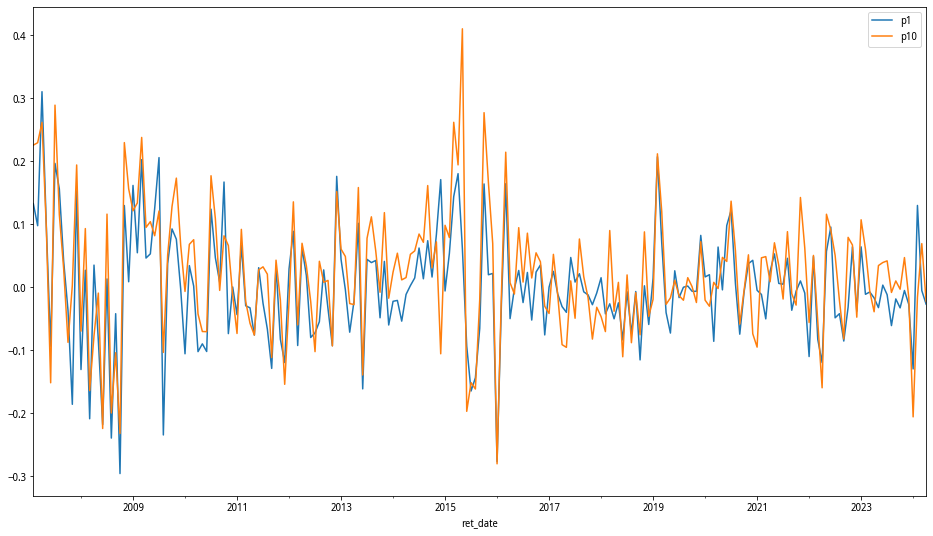

In [61]:
pd.DataFrame(portfolios_crs_mean)[['p1','p10']].plot()

## Double sort

In [62]:
ret_df.rename(columns={'illiq_1m':'illiq'},inplace=True)

In [63]:
from myutils.factor_func import double_sort, factor, daily_factor

In [64]:
double_sort?

Signature:
double_sort(
    df,
    sort1,
    sort2='size',
    group_date='ym',
    merge_cols=['secID', 'ret_date'],
)
Docstring:
Double sorting. 
Arguments:
    sort1: variable 1 for sorting into 3 groups
    sort2: default is "size", sorting into 2 groups
    group_date: the dates upon which the factor exposures are sorted
    merge_cols: the columns
returns:
    portfolios containing 2*3 groups
File:      /srv/data/notes_py3/myutils/factor_func.py
Type:      function


In [65]:
portfolios = double_sort(ret_df, sort1='illiq')

In [66]:
portfolios

{'illiq1_size1':              secID ret_date       ym       ret     exret       size  \
 0      002051.XSHE  2007-07  2007-06  0.084480  0.081998  21.146571   
 1      600178.XSHG  2007-07  2007-06  0.171246  0.168765  21.249828   
 2      600578.XSHG  2007-07  2007-06  0.165449  0.162967  21.225388   
 3      601008.XSHG  2007-07  2007-06 -0.004110 -0.006591  21.284024   
 4      000514.XSHE  2007-08  2007-07 -0.124571 -0.126974  21.262089   
 5      000565.XSHE  2007-08  2007-07 -0.107408 -0.109812  21.390840   
 6      600116.XSHG  2007-08  2007-07 -0.022585 -0.024988  20.899163   
 7      600199.XSHG  2007-08  2007-07 -0.076652 -0.079056  21.460322   
 ...            ...      ...      ...       ...       ...        ...   
 16743  600178.XSHG  2007-05  2007-04  0.043615  0.041088  21.335549   
 16744  600227.XSHG  2007-05  2007-04  0.065150  0.062623  21.249363   
 16745  600303.XSHG  2007-05  2007-04  0.118673  0.116146  21.231079   
 16746  600377.XSHG  2007-05  2007-04  0.054804 

In [67]:
mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
#     print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有illiq和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['illiq1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

illiq1_size1  illiq1_size2  illiq2_size1  illiq2_size2  \
ret_mean     -0.009561      0.003152      0.010749      0.009423   
t_values     -1.358983      0.456142      1.488528      1.390014   

          illiq3_size1  illiq3_size2  
ret_mean      0.021132      0.009973  
t_values      2.790338      1.521181

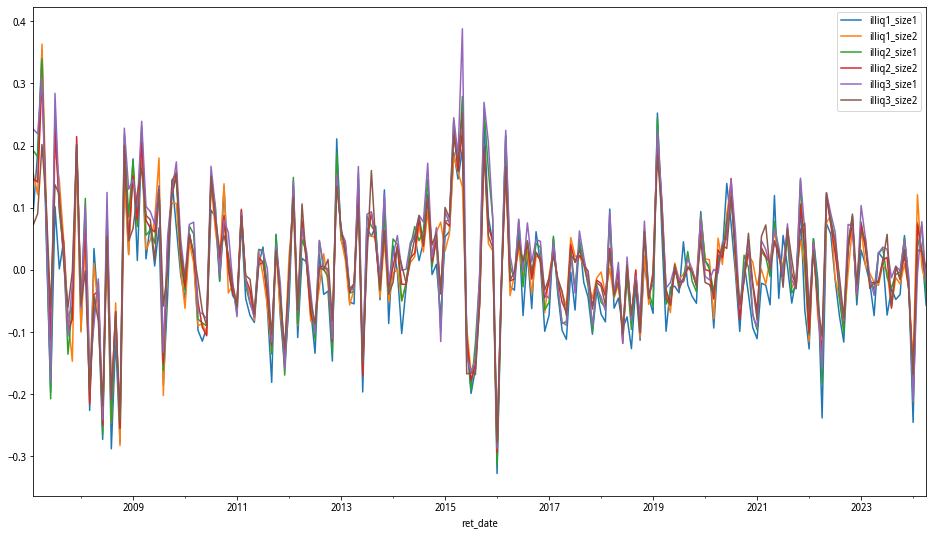

In [68]:
mean_portfolios_ret_df.plot()

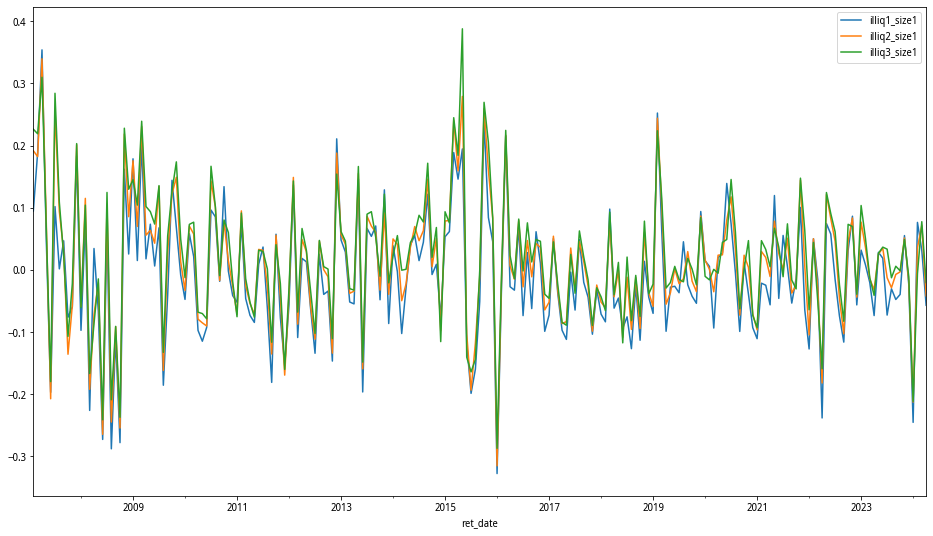

In [69]:
# Within mktcap1, any difference in illiq groups?
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[-5:] == 'size1'])
mean_portfolios_ret_df[cols].plot()

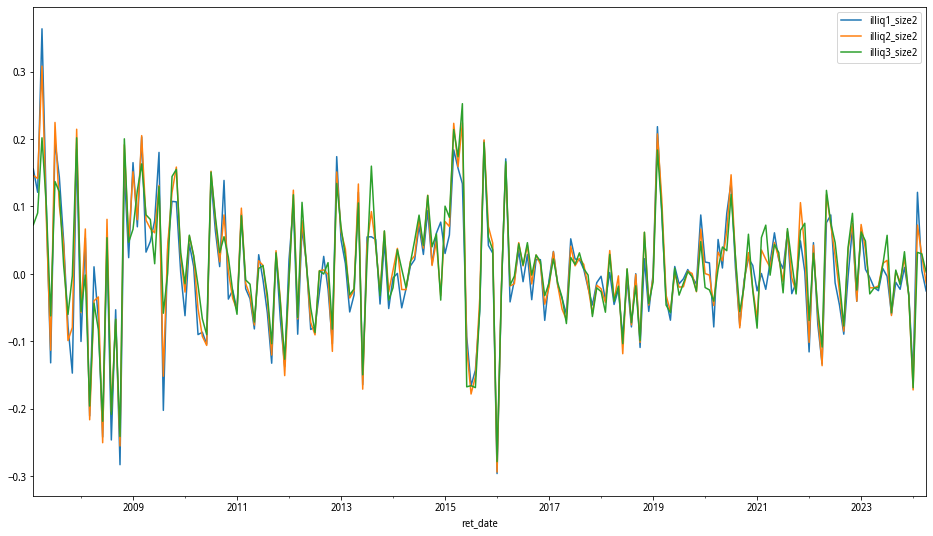

In [70]:
# Within mktcap1, any difference in illiq groups?
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[-5:] == 'size2'])
mean_portfolios_ret_df[cols].plot()

## FM regression

In [71]:
def fm_reg(df,cols):
    df_  = df.dropna()
    if df_.shape[0] < 15:
        return [None]*(len(cols)+1)
    reg = LinearRegression(fit_intercept=True).fit(y=df_.loc[:,'exret'], X=df_.loc[:,cols])
    return np.insert(reg.coef_, 0, reg.intercept_)

In [72]:
cols = ['illiq']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept     illiq
ret_mean   0.001879  7.823633
t_values   0.284379  2.379265

In [73]:
cols = ['beta','size','bm','mom','rev','illiq']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom      rev  \
ret_mean   0.046554  0.000279 -0.002227  0.007002 -0.001056 -0.04897   
t_values   1.428482  0.068471 -1.702311  1.695396 -0.391530 -6.35014   

              illiq  
ret_mean  11.563224  
t_values   5.849645

# Illiquidity factor

### Long-short factor

In [74]:
illiq_df = factor(ret_df, sort1='illiq', long_only=False)

In [75]:
illiq_df

ret_date
2007-02    0.056261
2007-03   -0.003323
2007-04   -0.070730
2007-05    0.021364
2007-06    0.014134
2007-07    0.081977
2007-08    0.021051
2007-09   -0.016609
             ...   
2023-09    0.032804
2023-10    0.021339
2023-11    0.012933
2023-12   -0.000875
2024-01   -0.026890
2024-02   -0.068260
2024-03    0.022674
2024-04    0.025725
Freq: M, Name: illiq, Length: 207, dtype: float64

In [76]:
factors_df = pd.read_pickle('./output_data/factors/ff3_rev.pkl')

In [77]:
factors_df.index = factors_df.index.to_period('M')

In [78]:
factors_df = pd.merge(factors_df,illiq_df,on='ret_date')

In [79]:
factors_df

exmktret       SMB       HML       rev     illiq
ret_date                                                  
2008-02   0.024010  0.081818  0.008108 -0.008397  0.002133
2008-03  -0.195480  0.015385 -0.026179  0.028792  0.024245
2008-04   0.022519 -0.114571  0.025498  0.084781 -0.113652
2008-05  -0.080798  0.065998 -0.005976  0.026674  0.017733
2008-06  -0.236014 -0.031857 -0.002291 -0.018469  0.028636
2008-07   0.014972  0.090812  0.013375  0.064280  0.045922
2008-08  -0.170063 -0.067974  0.027218  0.005248  0.017148
2008-09  -0.067913 -0.035740  0.031455  0.038855  0.020006
...            ...       ...       ...       ...       ...
2023-08  -0.062576  0.025097 -0.001984  0.019992  0.005266
2023-09  -0.018904  0.008117  0.010733  0.003359  0.032804
2023-10  -0.032835  0.026110 -0.010204 -0.024957  0.021339
2023-11  -0.017006  0.052774 -0.018800 -0.000589  0.012933
2023-12  -0.021342  0.006719  0.001391  0.003816 -0.000875
2024-01  -0.084298 -0.126380  0.107248 -0.028865 -0.026890
2024-02   0.102804 -0.068577 -0.045710  0.092135 -0.068260
2024-03  -0.000526  0.061925 -0.016510  0.032481  0.022674

[194 rows x 5 columns]

In [80]:
rf_df = ret_df[['ret_date','rf']].drop_duplicates().sort_values('ret_date').dropna()

In [81]:
factors_df = pd.merge(rf_df,factors_df,on='ret_date').set_index('ret_date')

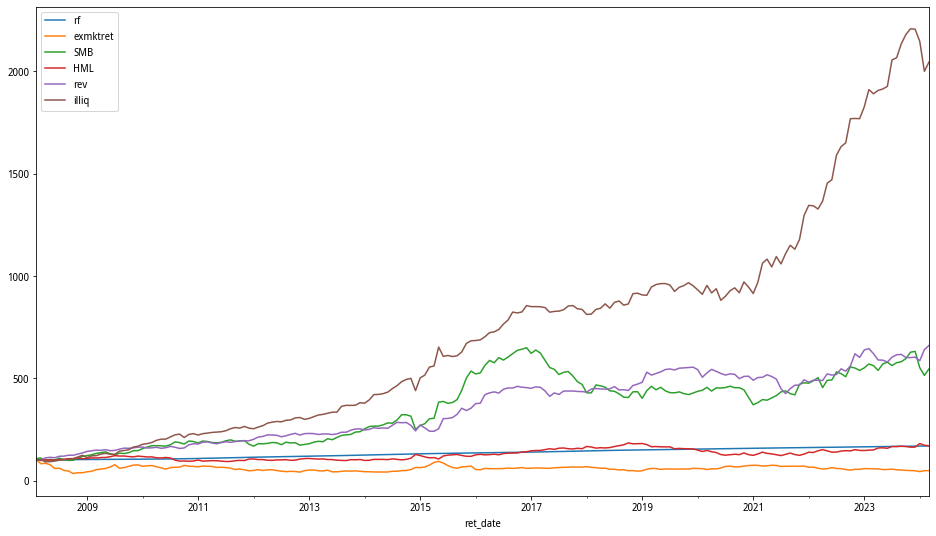

In [82]:
((factors_df+1).cumprod()*100).plot()

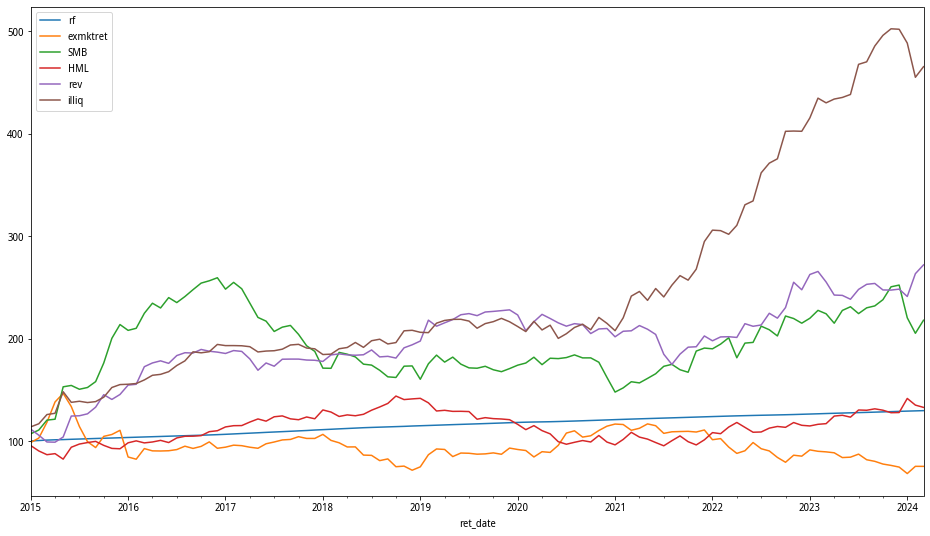

In [83]:
((factors_df['2015':]+1).cumprod()*100).plot()

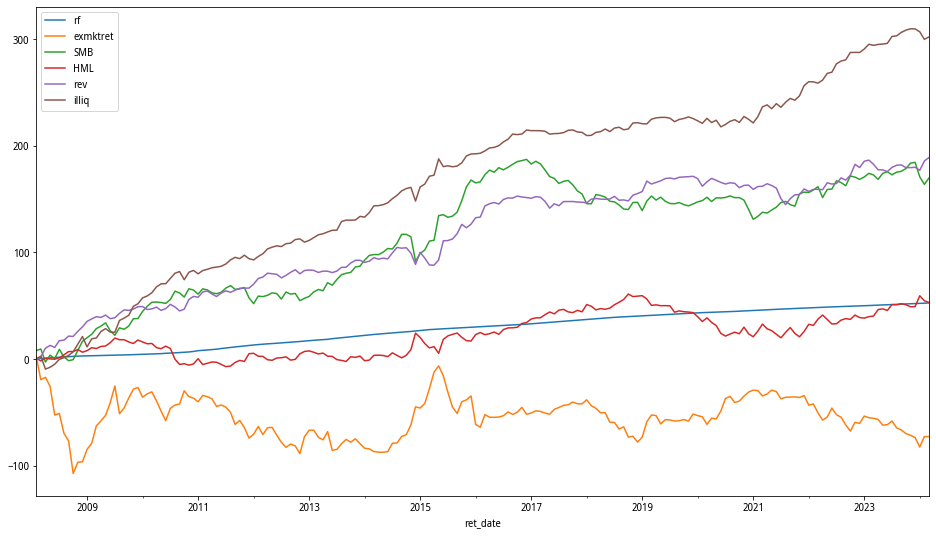

In [84]:
(np.log(1 + factors_df).cumsum()*100).plot()

### Long-only factor

In [85]:
illiq_long_df = factor(ret_df, sort1='illiq')

In [86]:
illiq_long_df

ret_date
2007-02    0.147877
2007-03    0.145453
2007-04    0.257292
2007-05    0.089519
2007-06   -0.120417
2007-07    0.228057
2007-08    0.114996
2007-09    0.028461
             ...   
2023-09    0.009877
2023-10   -0.008774
2023-11    0.041718
2023-12   -0.020613
2024-01   -0.182079
2024-02    0.022659
2024-03    0.045175
2024-04   -0.006964
Freq: M, Name: illiq, Length: 207, dtype: float64

In [94]:
factors_long_df = pd.read_pickle('./output_data/factors/ff3_rev_long_only.pkl')

In [95]:
factors_long_df.index = factors_long_df.index.to_period('M')

In [96]:
factors_long_df = pd.merge(factors_long_df,illiq_long_df,on='ret_date')

In [97]:
factors_long_df = pd.merge(rf_df,factors_long_df,on='ret_date').set_index('ret_date')

In [98]:
factors_long_df.rename(columns={'illiq':'illiq_long'},inplace=True)

In [99]:
factors_long_df

rf  exmktret  small_only  high_only  rev_long  illiq_long
ret_date                                                                 
2008-02   0.002946  0.024010    0.103117   0.059319  0.061681    0.054128
2008-03   0.002746 -0.195480   -0.180562  -0.202495 -0.166628   -0.180816
2008-04   0.002862  0.022519   -0.073326  -0.010688  0.023537   -0.063553
2008-05   0.002953 -0.080798   -0.020022  -0.056407 -0.041286   -0.061992
2008-06   0.003113 -0.236014   -0.257252  -0.239010 -0.249574   -0.218804
2008-07   0.002806  0.014972    0.108774   0.072304  0.086499    0.084925
2008-08   0.002681 -0.170063   -0.232768  -0.187431 -0.203066   -0.206455
2008-09   0.002889 -0.067913   -0.089285  -0.068049 -0.063174   -0.065761
...            ...       ...         ...        ...       ...         ...
2023-08   0.001594 -0.062576   -0.033271  -0.046533 -0.037027   -0.037344
2023-09   0.001904 -0.018904    0.000098  -0.000625 -0.007526    0.009877
2023-10   0.001890 -0.032835   -0.003186  -0.025060 -0.029482   -0.008774
2023-11   0.001914 -0.017006    0.048927   0.010436  0.025713    0.041718
2023-12   0.002068 -0.021342   -0.015419  -0.019122 -0.017794   -0.020613
2024-01   0.001902 -0.084298   -0.210021  -0.084317 -0.185138   -0.182079
2024-02   0.001749  0.102804    0.025233   0.035357  0.120001    0.022659
2024-03   0.001783 -0.000526    0.069588   0.028328  0.052248    0.045175

[194 rows x 6 columns]

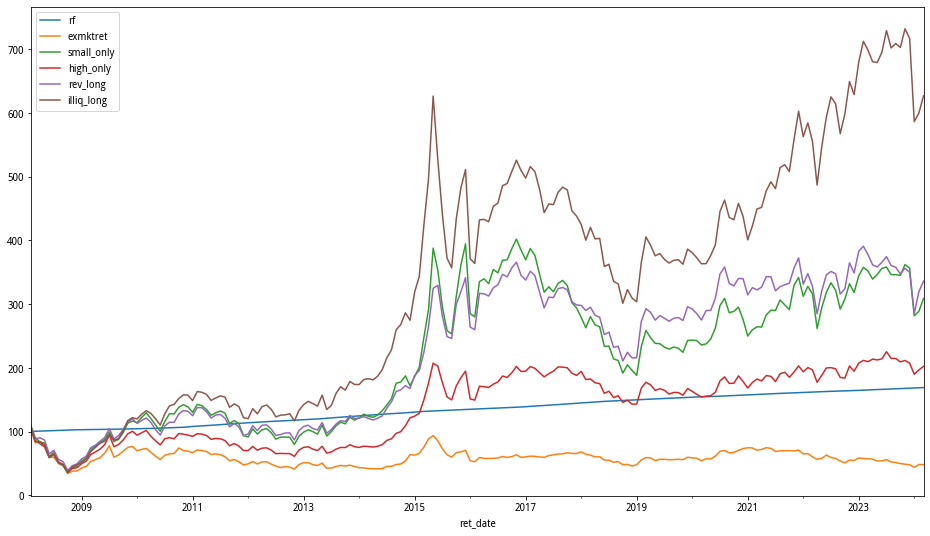

In [100]:
((factors_long_df+1).cumprod()*100).plot()

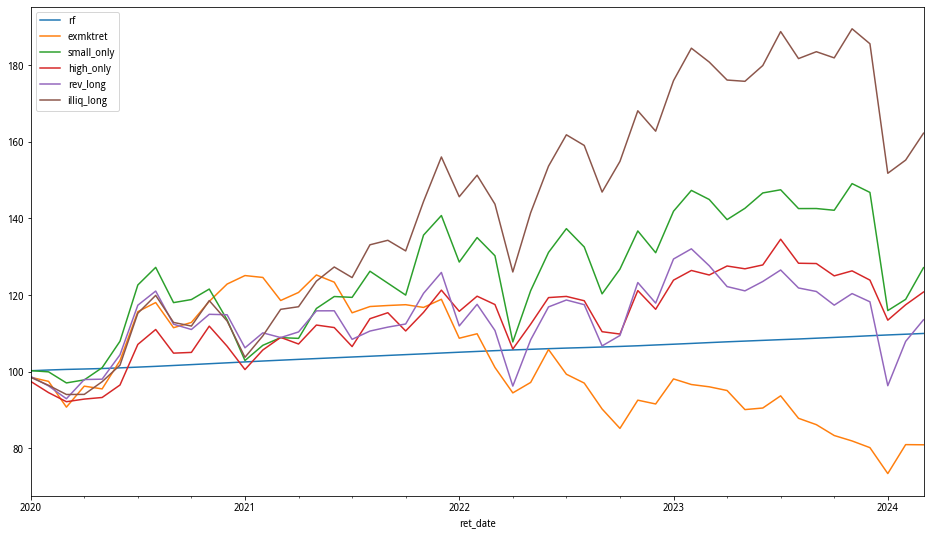

In [101]:
((1 + factors_long_df['2020':]).cumprod()*100).plot()

# Volatility

## Raw volatility

In [102]:
stk_df

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2007-06-20        824.193     987.007    4.835036e+10   
1         000001.XSHE 2007-06-21        987.007    1085.740    5.318694e+10   
2         000001.XSHE 2007-06-22       1085.740    1120.233    5.487665e+10   
3         000001.XSHE 2007-06-25       1120.233    1113.904    5.456661e+10   
4         000001.XSHE 2007-06-26       1113.904    1113.904    5.456661e+10   
5         000001.XSHE 2007-06-27       1113.904    1019.602    4.994705e+10   
6         000001.XSHE 2007-06-28       1019.602     953.780    4.672266e+10   
7         000001.XSHE 2007-06-29        953.780     870.870    4.266117e+10   
...               ...        ...            ...         ...             ...   
12395394  689009.XSHG 2024-04-01         29.950      31.050    1.600553e+10   
12395395  689009.XSHG 2024-04-02         31.050      30.370    1.565501e+10   
12395396  689009.XSHG 2024-04-03         30.370      29.320    1.511376e+10   
12395397  689009.XSHG 2024-04-08         29.320      27.500    1.417559e+10   
12395398  689009.XSHG 2024-04-09         27.500      28.070    1.446941e+10   
12395399  689009.XSHG 2024-04-10         28.070      27.570    1.421167e+10   
12395400  689009.XSHG 2024-04-11         27.570      27.330    1.408796e+10   
12395401  689009.XSHG 2024-04-12         27.330      27.800    1.433023e+10   

          turnoverValue  turnoverRate  ret_daily   illiq_daily       ym  \
0          4.182345e+09        0.0840   0.197544  4.723272e-11  2007-06   
1          2.285485e+09        0.0440   0.100033  4.376871e-11  2007-06   
2          2.761567e+09        0.0510   0.031769  1.150402e-11  2007-06   
3          2.324186e+09        0.0426  -0.005650  2.430837e-12  2007-06   
4          0.000000e+00        0.0000   0.000000           NaN  2007-06   
5          2.446556e+09        0.0489  -0.084659  3.460334e-11  2007-06   
6          1.617434e+09        0.0336  -0.064557  3.991295e-11  2007-06   
7          1.410758e+09        0.0316  -0.086928  6.161781e-11  2007-06   
...                 ...           ...        ...           ...      ...   
12395394   1.891675e+08        0.0120   0.036728  1.941554e-10  2024-04   
12395395   1.320106e+08        0.0084  -0.021900  1.658970e-10  2024-04   
12395396   1.629004e+08        0.0107  -0.034574  2.122376e-10  2024-04   
12395397   2.572971e+08        0.0179  -0.062074  2.412529e-10  2024-04   
12395398   1.401048e+08        0.0098   0.020727  1.479413e-10  2024-04   
12395399   1.128337e+08        0.0080  -0.017813  1.578660e-10  2024-04   
12395400   1.264233e+08        0.0089  -0.008705  6.885686e-11  2024-04   
12395401   1.743296e+08        0.0121   0.017197  9.864775e-11  2024-04   

            illiq_240d  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN  
...                ...  
12395394  1.187860e-10  
12395395  1.190462e-10  
12395396  1.195831e-10  
12395397  1.201377e-10  
12395398  1.206394e-10  
12395399  1.212019e-10  
12395400  1.212513e-10  
12395401  1.212628e-10  

[12395402 rows x 11 columns]

In [103]:
vol_df = stk_df.groupby(['secID','ym'])['ret_daily'].std()

In [104]:
vol_df

secID        ym     
000001.XSHE  2007-06    0.098564
             2007-07    0.041604
             2007-08    0.033926
             2007-09    0.023872
             2007-10    0.035921
             2007-11    0.033184
             2007-12    0.026541
             2008-01    0.037722
                          ...   
689009.XSHG  2023-09    0.014750
             2023-10    0.019076
             2023-11    0.017594
             2023-12    0.024634
             2024-01    0.024607
             2024-02    0.044243
             2024-03    0.030206
             2024-04    0.032460
Name: ret_daily, Length: 617652, dtype: float64

In [105]:
vol_df = vol_df.to_frame()

In [106]:
vol_df.columns = ['vol']
vol_df.reset_index(inplace=True)

MIN_NOBS = 15
idx = stk_df.groupby(['secID','ym'],as_index=False)['tradeDate'].count()['tradeDate'] < MIN_NOBS

vol_df.loc[idx, 'vol'] = np.nan

In [107]:
vol_df

secID       ym       vol
0       000001.XSHE  2007-06       NaN
1       000001.XSHE  2007-07  0.041604
2       000001.XSHE  2007-08  0.033926
3       000001.XSHE  2007-09  0.023872
4       000001.XSHE  2007-10  0.035921
5       000001.XSHE  2007-11  0.033184
6       000001.XSHE  2007-12  0.026541
7       000001.XSHE  2008-01  0.037722
...             ...      ...       ...
617644  689009.XSHG  2023-09  0.014750
617645  689009.XSHG  2023-10  0.019076
617646  689009.XSHG  2023-11  0.017594
617647  689009.XSHG  2023-12  0.024634
617648  689009.XSHG  2024-01  0.024607
617649  689009.XSHG  2024-02  0.044243
617650  689009.XSHG  2024-03  0.030206
617651  689009.XSHG  2024-04       NaN

[617652 rows x 3 columns]

下部分需要用到日度因子收益率，先运行 5-factors.ipynb

## Idiosyncratic volatility

Idiosyncratic volatility 指的是被已有的因子收益率回归之后，剩下的残差的波动率。传统金融理论认为残差部分属于可分散的风险，不应该被定价。即使认为因子模型还不够好，残差部分有剩余未被解释的系统性风险的部分，这部分的风险溢价(factor risk premium)也应该是正的。然而，美国市场的数据发现，波动率越低，未来的收益越高。这是一个很有意思的异象。

最广为人知的文献是 Ang, Hodrick, Xing, and Zhang (2006)。

- Bali and Cakici (2008): 数据处理的细节对结果影响很大，包括数据频率、portfolio加权的方式、分位点的计算等等
- Huang et al. (2010 RFS): 这个异象和 reversal 有关
- 其他部分文献：Han and Lesmond (2011), Bali, Cakici, and Whitelaw (2011), Baker, Bradley, and Wurgler (2011), Baker and Wurgler (2014)

我们每个月用因子模型计算一下ivol，用来排序。

#### Daily factors

In [108]:
pd.read_pickle('./output_data/factors/factors_daily.pkl')

rf  exmktret      size        bm       mom       rev
tradeDate                                                             
2007-02-01  0.000048  0.005542  0.002193  0.007141       NaN       NaN
2007-02-02  0.000048 -0.035335  0.018346  0.010887       NaN       NaN
2007-02-05  0.000048 -0.005993  0.019852  0.009071       NaN       NaN
2007-02-06  0.000049  0.019879  0.006771  0.005678       NaN       NaN
2007-02-07  0.000050  0.021923 -0.007161 -0.004263       NaN       NaN
2007-02-08  0.000052  0.017380 -0.000822  0.004951       NaN       NaN
2007-02-09  0.000076 -0.003355  0.003797  0.001221       NaN       NaN
2007-02-12  0.000110  0.033455 -0.009410 -0.005880       NaN       NaN
...              ...       ...       ...       ...       ...       ...
2024-04-01  0.000047  0.017766  0.008277 -0.001234 -0.013083  0.007626
2024-04-02  0.000047 -0.004091  0.003097  0.015831 -0.002311 -0.006347
2024-04-03  0.000046 -0.003030 -0.007240  0.011228  0.005311 -0.002610
2024-04-08  0.000047 -0.010232 -0.018479  0.002853  0.019388 -0.005804
2024-04-09  0.000047  0.001500  0.015436  0.000616 -0.019958  0.008483
2024-04-10  0.000047 -0.009355 -0.014298  0.005866  0.009825 -0.004603
2024-04-11  0.000047  0.001149 -0.000967  0.003639  0.004611 -0.000285
2024-04-12  0.000047 -0.007251 -0.002197 -0.002438  0.008133 -0.009208

[4179 rows x 6 columns]

In [109]:
shibor1d = DataAPI.MktIborGet(secID="Shibor1D.IRCN",beginDate=START,endDate=END,field=['tradeDate','rate'],pandas="1")
shibor1d['tradeDate'] = pd.to_datetime(shibor1d['tradeDate'])
shibor1d['rate'] = shibor1d['rate'] * 0.01 / 365
shibor1d.rename(columns={'rate':'rf'},inplace=True)

In [110]:
factors_daily = pd.read_pickle('./output_data/factors/factors_daily.pkl')

In [111]:
illiq_daily = daily_factor(ret_df, stock_df=stk_df,sort1='illiq',long_only=False)

In [112]:
illiq_daily

tradeDate
2007-02-01    0.007441
2007-02-02    0.021398
2007-02-05    0.014869
2007-02-06   -0.011942
2007-02-07   -0.003747
2007-02-08    0.011539
2007-02-09    0.004863
2007-02-12   -0.003945
                ...   
2024-04-01    0.003744
2024-04-02    0.016930
2024-04-03    0.009041
2024-04-08   -0.012326
2024-04-09    0.012941
2024-04-10   -0.003681
2024-04-11   -0.002875
2024-04-12    0.003490
Name: illiq, Length: 4179, dtype: float64

In [113]:
illiq_daily.name = 'illiq'

In [114]:
factors_daily = pd.merge(factors_daily, illiq_daily, on='tradeDate')

In [115]:
factors_daily

rf  exmktret      size        bm       mom       rev  \
tradeDate                                                                
2007-02-01  0.000048  0.005542  0.002193  0.007141       NaN       NaN   
2007-02-02  0.000048 -0.035335  0.018346  0.010887       NaN       NaN   
2007-02-05  0.000048 -0.005993  0.019852  0.009071       NaN       NaN   
2007-02-06  0.000049  0.019879  0.006771  0.005678       NaN       NaN   
2007-02-07  0.000050  0.021923 -0.007161 -0.004263       NaN       NaN   
2007-02-08  0.000052  0.017380 -0.000822  0.004951       NaN       NaN   
2007-02-09  0.000076 -0.003355  0.003797  0.001221       NaN       NaN   
2007-02-12  0.000110  0.033455 -0.009410 -0.005880       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-04-01  0.000047  0.017766  0.008277 -0.001234 -0.013083  0.007626   
2024-04-02  0.000047 -0.004091  0.003097  0.015831 -0.002311 -0.006347   
2024-04-03  0.000046 -0.003030 -0.007240  0.011228  0.005311 -0.002610   
2024-04-08  0.000047 -0.010232 -0.018479  0.002853  0.019388 -0.005804   
2024-04-09  0.000047  0.001500  0.015436  0.000616 -0.019958  0.008483   
2024-04-10  0.000047 -0.009355 -0.014298  0.005866  0.009825 -0.004603   
2024-04-11  0.000047  0.001149 -0.000967  0.003639  0.004611 -0.000285   
2024-04-12  0.000047 -0.007251 -0.002197 -0.002438  0.008133 -0.009208   

               illiq  
tradeDate             
2007-02-01  0.007441  
2007-02-02  0.021398  
2007-02-05  0.014869  
2007-02-06 -0.011942  
2007-02-07 -0.003747  
2007-02-08  0.011539  
2007-02-09  0.004863  
2007-02-12 -0.003945  
...              ...  
2024-04-01  0.003744  
2024-04-02  0.016930  
2024-04-03  0.009041  
2024-04-08 -0.012326  
2024-04-09  0.012941  
2024-04-10 -0.003681  
2024-04-11 -0.002875  
2024-04-12  0.003490  

[4179 rows x 7 columns]

#### 计算月度的 idiosyncratic volatility

In [116]:
def idiovol_np(df, factor_cols, len_periods='1m', min_nobs=15):
    """
    df: year_month is set as index
    """
    year_months = df.index.unique()
    n = len(year_months)
    idiovol = np.full(shape=n, fill_value=np.nan)
    start_notnan_month = int(len_periods[:-1])-1
    for i in range(start_notnan_month,n):
        df_ = df.loc[str(year_months[i]-int(len_periods[:-1])+1) : str(year_months[i]),['exret']+factor_cols].dropna().to_numpy()
        if len(df_) < min_nobs:
            continue
        else:
            y_ = df_[:,0] # 
            X_ = df_[:,1:]
            reg = LinearRegression().fit(y=y_, X=X_)
            res = y_ - reg.predict(X_)
            idiovol[i] = np.std(res)
    idiovol_df = pd.DataFrame({'ym': year_months, f'idiovol{len_periods}': idiovol})
    return idiovol_df

In [117]:
def idiovol(df,factor_cols,min_nobs=15):
    df = df.dropna()
    y = df.loc[:,'exret']
    X = df.loc[:,factor_cols]
    nobs = len(X)
    if nobs < min_nobs:
        idiovol = np.nan
    else:
        reg = LinearRegression().fit(y=y,X=X)
        res = y - reg.predict(X)
        idiovol = np.std(res)
    return idiovol

In [118]:
reg_df = pd.merge(stk_df[['secID','tradeDate','ret_daily']],factors_daily,
                  on=['tradeDate'])

In [119]:
reg_df

secID  tradeDate  ret_daily        rf  exmktret      size  \
0         000001.XSHE 2007-06-20   0.197544  0.000073 -0.024256 -0.003004   
1         000002.XSHE 2007-06-20  -0.035577  0.000073 -0.024256 -0.003004   
2         000006.XSHE 2007-06-20  -0.030451  0.000073 -0.024256 -0.003004   
3         000007.XSHE 2007-06-20        NaN  0.000073 -0.024256 -0.003004   
4         000008.XSHE 2007-06-20        NaN  0.000073 -0.024256 -0.003004   
5         000012.XSHE 2007-06-20  -0.066159  0.000073 -0.024256 -0.003004   
6         000014.XSHE 2007-06-20  -0.002394  0.000073 -0.024256 -0.003004   
7         000016.XSHE 2007-06-20  -0.050821  0.000073 -0.024256 -0.003004   
...               ...        ...        ...       ...       ...       ...   
12371862  601607.XSHG 2007-06-19   0.100267  0.000071  0.009520  0.008822   
12371863  601628.XSHG 2007-06-19  -0.018618  0.000071  0.009520  0.008822   
12371864  601666.XSHG 2007-06-19  -0.003302  0.000071  0.009520  0.008822   
12371865  601699.XSHG 2007-06-19   0.043605  0.000071  0.009520  0.008822   
12371866  601872.XSHG 2007-06-19   0.099859  0.000071  0.009520  0.008822   
12371867  601988.XSHG 2007-06-19  -0.001866  0.000071  0.009520  0.008822   
12371868  601991.XSHG 2007-06-19   0.100027  0.000071  0.009520  0.008822   
12371869  601998.XSHG 2007-06-19  -0.012695  0.000071  0.009520  0.008822   

                bm  mom       rev     illiq  
0        -0.000760  NaN -0.001559  0.000541  
1        -0.000760  NaN -0.001559  0.000541  
2        -0.000760  NaN -0.001559  0.000541  
3        -0.000760  NaN -0.001559  0.000541  
4        -0.000760  NaN -0.001559  0.000541  
5        -0.000760  NaN -0.001559  0.000541  
6        -0.000760  NaN -0.001559  0.000541  
7        -0.000760  NaN -0.001559  0.000541  
...            ...  ...       ...       ...  
12371862  0.004264  NaN  0.000622 -0.009446  
12371863  0.004264  NaN  0.000622 -0.009446  
12371864  0.004264  NaN  0.000622 -0.009446  
12371865  0.004264  NaN  0.000622 -0.009446  
12371866  0.004264  NaN  0.000622 -0.009446  
12371867  0.004264  NaN  0.000622 -0.009446  
12371868  0.004264  NaN  0.000622 -0.009446  
12371869  0.004264  NaN  0.000622 -0.009446  

[12371870 rows x 10 columns]

In [120]:
reg_df.sort_values(['secID','tradeDate'],inplace=True)

In [121]:
reg_df

secID  tradeDate  ret_daily        rf  exmktret      size  \
0         000001.XSHE 2007-06-20   0.197544  0.000073 -0.024256 -0.003004   
1290      000001.XSHE 2007-06-21   0.100033  0.000064  0.005827 -0.009497   
2580      000001.XSHE 2007-06-22   0.031769  0.000058 -0.040473 -0.017067   
3870      000001.XSHE 2007-06-25  -0.005650  0.000052 -0.048566 -0.018312   
5160      000001.XSHE 2007-06-26   0.000000  0.000049  0.014660 -0.000199   
6451      000001.XSHE 2007-06-27  -0.084659  0.000047  0.027391 -0.002727   
7742      000001.XSHE 2007-06-28  -0.064557  0.000046 -0.050035 -0.022209   
9033      000001.XSHE 2007-06-29  -0.086928  0.000049 -0.029572 -0.016960   
...               ...        ...        ...       ...       ...       ...   
12225217  689009.XSHG 2024-04-01   0.036728  0.000047  0.017766  0.008277   
12230330  689009.XSHG 2024-04-02  -0.021900  0.000047 -0.004091  0.003097   
12235443  689009.XSHG 2024-04-03  -0.034574  0.000046 -0.003030 -0.007240   
12240557  689009.XSHG 2024-04-08  -0.062074  0.000047 -0.010232 -0.018479   
12245671  689009.XSHG 2024-04-09   0.020727  0.000047  0.001500  0.015436   
12250785  689009.XSHG 2024-04-10  -0.017813  0.000047 -0.009355 -0.014298   
12255900  689009.XSHG 2024-04-11  -0.008705  0.000047  0.001149 -0.000967   
12261015  689009.XSHG 2024-04-12   0.017197  0.000047 -0.007251 -0.002197   

                bm       mom       rev     illiq  
0        -0.000760       NaN -0.001559  0.000541  
1290      0.001252       NaN  0.007577 -0.008228  
2580     -0.012254       NaN -0.005417  0.009722  
3870     -0.014716       NaN -0.004875  0.004986  
5160      0.014121       NaN  0.009540  0.002795  
6451     -0.007487       NaN -0.005338 -0.002271  
7742     -0.000901       NaN  0.002548  0.002782  
9033      0.005592       NaN  0.001984 -0.000487  
...            ...       ...       ...       ...  
12225217 -0.001234 -0.013083  0.007626  0.003744  
12230330  0.015831 -0.002311 -0.006347  0.016930  
12235443  0.011228  0.005311 -0.002610  0.009041  
12240557  0.002853  0.019388 -0.005804 -0.012326  
12245671  0.000616 -0.019958  0.008483  0.012941  
12250785  0.005866  0.009825 -0.004603 -0.003681  
12255900  0.003639  0.004611 -0.000285 -0.002875  
12261015 -0.002438  0.008133 -0.009208  0.003490  

[12371870 rows x 10 columns]

In [122]:
reg_df['exret'] = reg_df['ret_daily'] - reg_df['rf']

In [123]:
reg_df['ym'] = reg_df['tradeDate'].dt.to_period('M')

#### 代码测试

In [124]:
# Testing the time consuming 
ids = reg_df['secID'].unique()
ids_ = np.random.choice(ids, 50)
temp = reg_df[reg_df['secID'].isin(ids_)]

In [125]:
temp.set_index('ym',inplace=True)

In [126]:
temp

secID  tradeDate  ret_daily        rf  exmktret      size  \
ym                                                                         
2007-02  000518.XSHE 2007-02-01  -0.007430  0.000048  0.005542  0.002193   
2007-02  000518.XSHE 2007-02-02  -0.018826  0.000048 -0.035335  0.018346   
2007-02  000518.XSHE 2007-02-05   0.015349  0.000048 -0.005993  0.019852   
2007-02  000518.XSHE 2007-02-06   0.060380  0.000049  0.019879  0.006771   
2007-02  000518.XSHE 2007-02-07   0.000000  0.000050  0.021923 -0.007161   
2007-02  000518.XSHE 2007-02-08   0.028471  0.000052  0.017380 -0.000822   
2007-02  000518.XSHE 2007-02-09   0.072652  0.000076 -0.003355  0.003797   
2007-02  000518.XSHE 2007-02-12   0.006462  0.000110  0.033455 -0.009410   
...              ...        ...        ...       ...       ...       ...   
2024-04  688719.XSHG 2024-04-01   0.059266  0.000047  0.017766  0.008277   
2024-04  688719.XSHG 2024-04-02  -0.016701  0.000047 -0.004091  0.003097   
2024-04  688719.XSHG 2024-04-03  -0.016985  0.000046 -0.003030 -0.007240   
2024-04  688719.XSHG 2024-04-08  -0.011447  0.000047 -0.010232 -0.018479   
2024-04  688719.XSHG 2024-04-09   0.004370  0.000047  0.001500  0.015436   
2024-04  688719.XSHG 2024-04-10   0.014140  0.000047 -0.009355 -0.014298   
2024-04  688719.XSHG 2024-04-11   0.045689  0.000047  0.001149 -0.000967   
2024-04  688719.XSHG 2024-04-12  -0.005949  0.000047 -0.007251 -0.002197   

               bm       mom       rev     illiq     exret  
ym                                                         
2007-02  0.007141       NaN       NaN  0.007441 -0.007478  
2007-02  0.010887       NaN       NaN  0.021398 -0.018874  
2007-02  0.009071       NaN       NaN  0.014869  0.015301  
2007-02  0.005678       NaN       NaN -0.011942  0.060331  
2007-02 -0.004263       NaN       NaN -0.003747 -0.000050  
2007-02  0.004951       NaN       NaN  0.011539  0.028419  
2007-02  0.001221       NaN       NaN  0.004863  0.072575  
2007-02 -0.005880       NaN       NaN -0.003945  0.006352  
...           ...       ...       ...       ...       ...  
2024-04 -0.001234 -0.013083  0.007626  0.003744  0.059218  
2024-04  0.015831 -0.002311 -0.006347  0.016930 -0.016748  
2024-04  0.011228  0.005311 -0.002610  0.009041 -0.017031  
2024-04  0.002853  0.019388 -0.005804 -0.012326 -0.011494  
2024-04  0.000616 -0.019958  0.008483  0.012941  0.004323  
2024-04  0.005866  0.009825 -0.004603 -0.003681  0.014092  
2024-04  0.003639  0.004611 -0.000285 -0.002875  0.045641  
2024-04 -0.002438  0.008133 -0.009208  0.003490 -0.005996  

[124115 rows x 11 columns]

In [127]:
%%time
result1 = temp.groupby(['secID','ym']).apply(idiovol, factor_cols=['exmktret','size','bm','mom','rev','illiq'])

CPU times: user 30.5 s, sys: 68 ms, total: 30.6 s
Wall time: 30.6 s


In [128]:
%%time
result2 = temp.groupby(['secID']).apply(idiovol_np, factor_cols=['exmktret','size','bm','mom','rev','illiq'])

CPU times: user 21 s, sys: 228 ms, total: 21.3 s
Wall time: 21.2 s


In [129]:
result1

secID        ym     
000518.XSHE  2007-02         NaN
             2007-03         NaN
             2007-04         NaN
             2007-05         NaN
             2007-06         NaN
             2007-07         NaN
             2007-08         NaN
             2007-09         NaN
                          ...   
688719.XSHG  2023-09         NaN
             2023-10    0.028392
             2023-11    0.030289
             2023-12    0.013844
             2024-01    0.025273
             2024-02    0.019099
             2024-03    0.016887
             2024-04         NaN
Length: 6177, dtype: float64

In [130]:
result2

ym  idiovol1m
secID                            
000518.XSHE 0  2007-02        NaN
            1  2007-03        NaN
            2  2007-04        NaN
            3  2007-05        NaN
            4  2007-06        NaN
            5  2007-07        NaN
            6  2007-08        NaN
            7  2007-09        NaN
...                ...        ...
688719.XSHG 0  2023-09        NaN
            1  2023-10   0.028392
            2  2023-11   0.030289
            3  2023-12   0.013844
            4  2024-01   0.025273
            5  2024-02   0.019099
            6  2024-03   0.016887
            7  2024-04        NaN

[6177 rows x 2 columns]

In [131]:
result1 = result1.to_frame().reset_index()
result1.columns = ['secID','ym','r1']

In [132]:
result2 = result2.reset_index().drop('level_1',axis=1)

In [133]:
result = pd.merge(result1, result2, on=['secID','ym'])

In [134]:
result

secID       ym        r1  idiovol1m
0     000518.XSHE  2007-02       NaN        NaN
1     000518.XSHE  2007-03       NaN        NaN
2     000518.XSHE  2007-04       NaN        NaN
3     000518.XSHE  2007-05       NaN        NaN
4     000518.XSHE  2007-06       NaN        NaN
5     000518.XSHE  2007-07       NaN        NaN
6     000518.XSHE  2007-08       NaN        NaN
7     000518.XSHE  2007-09       NaN        NaN
...           ...      ...       ...        ...
6169  688719.XSHG  2023-09       NaN        NaN
6170  688719.XSHG  2023-10  0.028392   0.028392
6171  688719.XSHG  2023-11  0.030289   0.030289
6172  688719.XSHG  2023-12  0.013844   0.013844
6173  688719.XSHG  2024-01  0.025273   0.025273
6174  688719.XSHG  2024-02  0.019099   0.019099
6175  688719.XSHG  2024-03  0.016887   0.016887
6176  688719.XSHG  2024-04       NaN        NaN

[6177 rows x 4 columns]

In [135]:
(result['r1'] - result['idiovol1m']).sum()

-1.689205645927035e-16

In [136]:
result['r1'].to_numpy()

array([       nan,        nan,        nan, ..., 0.01909926, 0.01688694,
              nan])

In [137]:
result['idiovol1m'].to_numpy()

array([       nan,        nan,        nan, ..., 0.01909926, 0.01688694,
              nan])

In [138]:
np.array_equal(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

False

In [139]:
np.allclose(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

False

In [140]:
result.fillna(0, inplace=True)

In [141]:
np.array_equal(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

False

In [142]:
np.allclose(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

True

#### 实际计算

In [143]:
reg_df.set_index('ym',inplace=True)

In [144]:
reg_df

secID  tradeDate  ret_daily        rf  exmktret      size  \
ym                                                                         
2007-06  000001.XSHE 2007-06-20   0.197544  0.000073 -0.024256 -0.003004   
2007-06  000001.XSHE 2007-06-21   0.100033  0.000064  0.005827 -0.009497   
2007-06  000001.XSHE 2007-06-22   0.031769  0.000058 -0.040473 -0.017067   
2007-06  000001.XSHE 2007-06-25  -0.005650  0.000052 -0.048566 -0.018312   
2007-06  000001.XSHE 2007-06-26   0.000000  0.000049  0.014660 -0.000199   
2007-06  000001.XSHE 2007-06-27  -0.084659  0.000047  0.027391 -0.002727   
2007-06  000001.XSHE 2007-06-28  -0.064557  0.000046 -0.050035 -0.022209   
2007-06  000001.XSHE 2007-06-29  -0.086928  0.000049 -0.029572 -0.016960   
...              ...        ...        ...       ...       ...       ...   
2024-04  689009.XSHG 2024-04-01   0.036728  0.000047  0.017766  0.008277   
2024-04  689009.XSHG 2024-04-02  -0.021900  0.000047 -0.004091  0.003097   
2024-04  689009.XSHG 2024-04-03  -0.034574  0.000046 -0.003030 -0.007240   
2024-04  689009.XSHG 2024-04-08  -0.062074  0.000047 -0.010232 -0.018479   
2024-04  689009.XSHG 2024-04-09   0.020727  0.000047  0.001500  0.015436   
2024-04  689009.XSHG 2024-04-10  -0.017813  0.000047 -0.009355 -0.014298   
2024-04  689009.XSHG 2024-04-11  -0.008705  0.000047  0.001149 -0.000967   
2024-04  689009.XSHG 2024-04-12   0.017197  0.000047 -0.007251 -0.002197   

               bm       mom       rev     illiq     exret  
ym                                                         
2007-06 -0.000760       NaN -0.001559  0.000541  0.197470  
2007-06  0.001252       NaN  0.007577 -0.008228  0.099969  
2007-06 -0.012254       NaN -0.005417  0.009722  0.031711  
2007-06 -0.014716       NaN -0.004875  0.004986 -0.005702  
2007-06  0.014121       NaN  0.009540  0.002795 -0.000049  
2007-06 -0.007487       NaN -0.005338 -0.002271 -0.084706  
2007-06 -0.000901       NaN  0.002548  0.002782 -0.064602  
2007-06  0.005592       NaN  0.001984 -0.000487 -0.086977  
...           ...       ...       ...       ...       ...  
2024-04 -0.001234 -0.013083  0.007626  0.003744  0.036681  
2024-04  0.015831 -0.002311 -0.006347  0.016930 -0.021947  
2024-04  0.011228  0.005311 -0.002610  0.009041 -0.034620  
2024-04  0.002853  0.019388 -0.005804 -0.012326 -0.062121  
2024-04  0.000616 -0.019958  0.008483  0.012941  0.020680  
2024-04  0.005866  0.009825 -0.004603 -0.003681 -0.017860  
2024-04  0.003639  0.004611 -0.000285 -0.002875 -0.008752  
2024-04 -0.002438  0.008133 -0.009208  0.003490  0.017150  

[12371870 rows x 11 columns]

In [145]:
reg_df['secID'].nunique()

5299

In [146]:
# %%time
# ivol = reg_df.groupby(['secID']).apply(idiovol_np, factor_cols=['exmktret','size','bm','mom','rev','illiq'])
# # Takes about 32min to execute

CPU times: user 31min 58s, sys: 22.9 s, total: 32min 21s
Wall time: 32min 20s


In [147]:
# ivol = ivol.reset_index().drop('level_1',axis=1)

In [148]:
# ivol

secID       ym  idiovol1m
0       000001.XSHE  2007-06        NaN
1       000001.XSHE  2007-07        NaN
2       000001.XSHE  2007-08        NaN
3       000001.XSHE  2007-09        NaN
4       000001.XSHE  2007-10        NaN
5       000001.XSHE  2007-11        NaN
6       000001.XSHE  2007-12        NaN
7       000001.XSHE  2008-01   0.012909
...             ...      ...        ...
616455  689009.XSHG  2023-09   0.006809
616456  689009.XSHG  2023-10   0.011139
616457  689009.XSHG  2023-11   0.015128
616458  689009.XSHG  2023-12   0.018228
616459  689009.XSHG  2024-01   0.013890
616460  689009.XSHG  2024-02   0.024755
616461  689009.XSHG  2024-03   0.022928
616462  689009.XSHG  2024-04        NaN

[616463 rows x 3 columns]

In [149]:
# ivol.to_pickle('./data/idiovol1m.pkl')

In [150]:
ivol = pd.read_pickle('./data/idiovol1m.pkl')

In [151]:
vol_df = pd.merge(vol_df,ivol,on=['secID','ym'])

In [152]:
vol_df

secID       ym       vol  idiovol1m
0       000001.XSHE  2007-06       NaN        NaN
1       000001.XSHE  2007-07  0.041604        NaN
2       000001.XSHE  2007-08  0.033926        NaN
3       000001.XSHE  2007-09  0.023872        NaN
4       000001.XSHE  2007-10  0.035921        NaN
5       000001.XSHE  2007-11  0.033184        NaN
6       000001.XSHE  2007-12  0.026541        NaN
7       000001.XSHE  2008-01  0.037722   0.012909
...             ...      ...       ...        ...
616455  689009.XSHG  2023-09  0.014750   0.006809
616456  689009.XSHG  2023-10  0.019076   0.011139
616457  689009.XSHG  2023-11  0.017594   0.015128
616458  689009.XSHG  2023-12  0.024634   0.018228
616459  689009.XSHG  2024-01  0.024607   0.013890
616460  689009.XSHG  2024-02  0.044243   0.024755
616461  689009.XSHG  2024-03  0.030206   0.022928
616462  689009.XSHG  2024-04       NaN        NaN

[616463 rows x 4 columns]

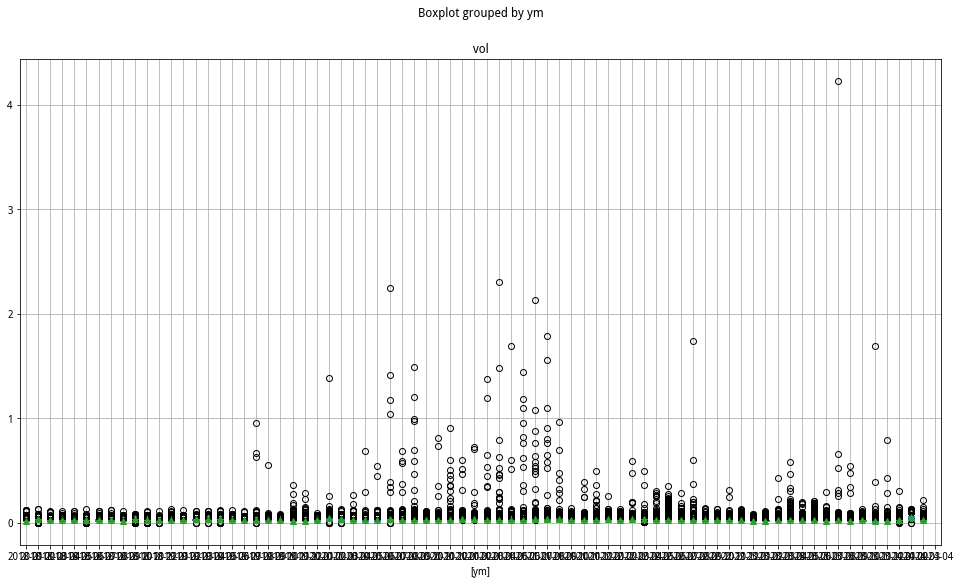

In [153]:
vol_df.loc[vol_df['ym']>='2018',['ym','vol']].boxplot(by='ym',showmeans=True)

In [154]:
vol_df['vol_clip'] = vol_df['vol'].clip(lower=vol_df['vol'].quantile(0.001),
                                        upper=vol_df['vol'].quantile(0.999))
vol_df['ivol_clip'] = vol_df['idiovol1m'].clip(lower=vol_df['idiovol1m'].quantile(0.001),
                                               upper=vol_df['idiovol1m'].quantile(0.999))

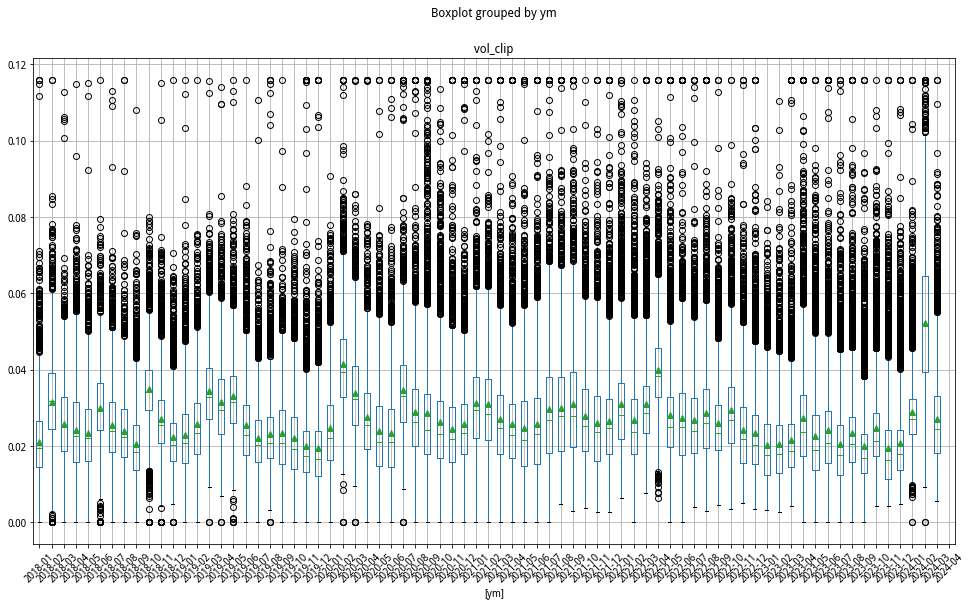

In [155]:
vol_df.loc[vol_df['ym']>='2018',['ym','vol_clip']].boxplot(by='ym',showmeans=True,rot=45)

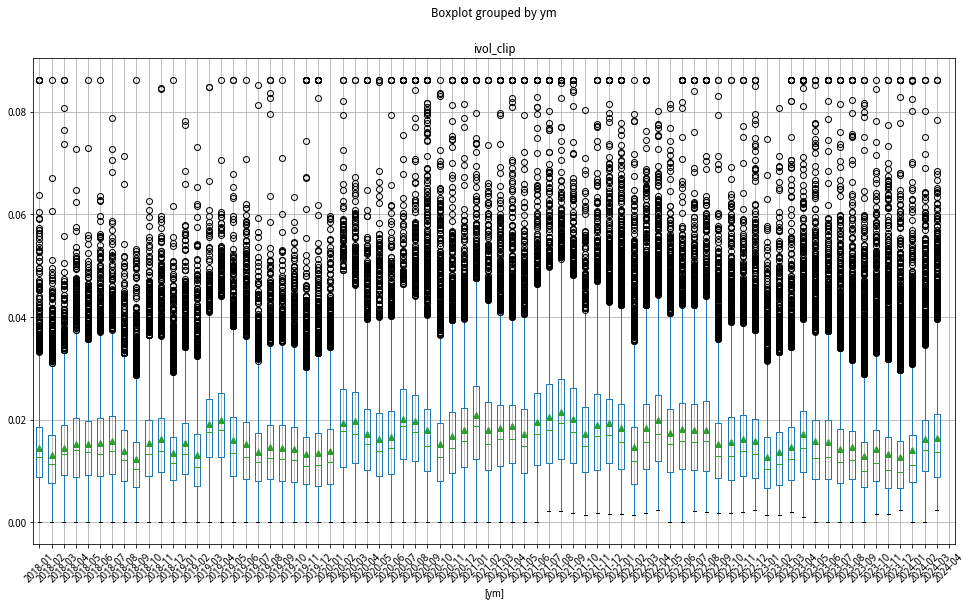

In [156]:
vol_df.loc[vol_df['ym']>='2018',['ym','ivol_clip']].boxplot(by='ym',showmeans=True,rot=45)

In [157]:
vol_df.loc[:,'vol':'ivol_clip'].describe()

vol     idiovol1m       vol_clip     ivol_clip
count  590794.000000  5.762880e+05  590794.000000  5.762880e+05
mean        0.027687  1.606061e-02       0.027462  1.591192e-02
std         0.021717  1.546969e-02       0.014021  9.664495e-03
min         0.000000  3.370719e-08       0.000000  3.566976e-07
25%         0.017805  9.174095e-03       0.017805  9.174095e-03
50%         0.024902  1.385151e-02       0.024902  1.385151e-02
75%         0.034570  2.058275e-02       0.034570  2.058275e-02
max         4.874535  3.675013e+00       0.115732  8.607782e-02

In [158]:
vol_df.rename(columns={'idiovol1m':'ivol'},inplace=True)

## Sorting and Factors

In [159]:
ret_df = pd.merge(ret_df,vol_df,
                  on=['secID','ym'])

In [160]:
ret_df

secID ret_date  tradeDate       ret        rf     exret  \
0       000001.XSHE  2007-07 2007-06-29  0.316497  0.002481  0.314016   
1       000001.XSHE  2007-08 2007-07-31  0.048855  0.002404  0.046451   
2       000001.XSHE  2007-09 2007-08-31  0.052105  0.002621  0.049484   
3       000001.XSHE  2007-10 2007-09-28  0.201851  0.003095  0.198756   
4       000001.XSHE  2007-11 2007-10-31 -0.249116  0.003780 -0.252896   
5       000001.XSHE  2007-12 2007-11-30  0.069845  0.003011  0.066834   
6       000001.XSHE  2008-01 2007-12-28 -0.137306  0.002949 -0.140255   
7       000001.XSHE  2008-02 2008-01-31 -0.004504  0.002946 -0.007450   
...             ...      ...        ...       ...       ...       ...   
616455  689009.XSHG  2023-10 2023-09-28 -0.058570  0.001890 -0.060460   
616456  689009.XSHG  2023-11 2023-10-31  0.009454  0.001914  0.007540   
616457  689009.XSHG  2023-12 2023-11-30 -0.103927  0.002068 -0.105996   
616458  689009.XSHG  2024-01 2023-12-29 -0.213082  0.001902 -0.214983   
616459  689009.XSHG  2024-02 2024-01-31  0.298201  0.001749  0.296451   
616460  689009.XSHG  2024-03 2024-02-29 -0.011551  0.001783 -0.013334   
616461  689009.XSHG  2024-04 2024-03-29 -0.071786  0.001687 -0.073474   
616462  689009.XSHG      NaT 2024-04-12       NaN       NaN       NaN   

             ym        mktcap       size       rev mom_date       mom    beta  \
0       2007-06  4.266117e+10  24.476555       NaN      NaT       NaN  0.4614   
1       2007-07  5.616330e+10  24.751529  0.314016  2007-06       NaN  0.6423   
2       2007-08  5.890714e+10  24.799228  0.046451  2007-07       NaN  0.7722   
3       2007-09  6.197651e+10  24.850021  0.049484  2007-08       NaN  0.7596   
4       2007-10  7.448652e+10  25.033884  0.198756  2007-09       NaN  0.7988   
5       2007-11  5.593078e+10  24.747381 -0.252896  2007-10       NaN  0.9560   
6       2007-12  6.574629e+10  24.909069  0.066834  2007-11       NaN  0.9468   
7       2008-01  5.850212e+10  24.792329 -0.140255  2007-12       NaN  0.9654   
...         ...           ...        ...       ...      ...       ...     ...   
616455  2023-09  1.785208e+10  23.605386  0.040598  2023-08 -0.127904  0.9152   
616456  2023-10  1.716478e+10  23.566125 -0.060460  2023-09  0.088437  0.9247   
616457  2023-11  1.732706e+10  23.575535  0.007540  2023-10 -0.017675  0.9541   
616458  2023-12  1.552630e+10  23.465801 -0.105996  2023-11  0.085602  1.0448   
616459  2024-01  1.221793e+10  23.226170 -0.214983  2023-12 -0.106357  1.2314   
616460  2024-02  1.586132e+10  23.487149  0.296451  2024-01 -0.292727  1.4905   
616461  2024-03  1.543851e+10  23.460131 -0.013334  2024-02 -0.195005  1.5477   
616462  2024-04  1.433023e+10  23.385637 -0.073474  2024-03 -0.104366     NaN   

              bm     illiq  illiq_12m       vol      ivol  vol_clip  ivol_clip  
0       0.123739       NaN        NaN       NaN       NaN       NaN        NaN  
1       0.093992  0.000040        NaN  0.041604       NaN  0.041604        NaN  
2       0.097085  0.000020        NaN  0.033926       NaN  0.033926        NaN  
3       0.092276  0.000025        NaN  0.023872       NaN  0.023872        NaN  
4       0.083411  0.000030        NaN  0.035921       NaN  0.035921        NaN  
5       0.111084  0.000048        NaN  0.033184       NaN  0.033184        NaN  
6       0.094476  0.000025        NaN  0.026541       NaN  0.026541        NaN  
7       0.109513  0.000039        NaN  0.037722  0.012909  0.037722   0.012909  
...          ...       ...        ...       ...       ...       ...        ...  
616455  0.209367  0.000114   0.000119  0.014750  0.006809  0.014750   0.006809  
616456  0.223899  0.000226   0.000118  0.019076  0.011139  0.019076   0.011139  
616457  0.221803  0.000086   0.000115  0.017594  0.015128  0.017594   0.015128  
616458  0.247525  0.000110   0.000107  0.024634  0.018228  0.024634   0.018228  
616459  0.313607  0.000184   0.000116  0.024607  0.013890  0.024607   0.013890  
616460  0.241569  0.00016

In [204]:
def single_sort(df, sort):
    q = dict()
    keys = ['q'+str(i) for i in range(1, 10)]
    values = np.arange(0.1, 1.0, 0.1)
    q.update(zip(keys,values))

    quantile_df = pd.DataFrame()
    for key, value in q.items():
        quantile_df[key] = df.groupby(['ym'])[sort].quantile(value)

    df_q = pd.merge(df, quantile_df, on='ym')

    portfolios = dict()
    drop_cols = [col for col in df_q.columns if col[0]=='q']

    portfolios['p1'] = df_q.loc[df_q[sort] <= df_q['q1']].copy().drop(drop_cols, axis=1)
    for i in range(2,10):
        idx = (df_q[f'q{i-1}'] <= df_q[sort]) & (df_q[sort] <= df_q[f'q{i}'])
        portfolios[f'p{i}'] = df_q.loc[idx].copy().drop(drop_cols, axis=1)
    portfolios['p10'] = df_q.loc[df_q[sort] >= df_q['q9']].copy().drop(drop_cols, axis=1)

    portfolios_crs_mean = dict()
    for k in portfolios.keys():
        portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

    mean_values = {}
    t_values = {}
    for k in portfolios_crs_mean.keys():
        y = portfolios_crs_mean[k]
        const = np.full(shape=len(y),fill_value=1)
        reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
        mean_values[k] = reg.params[0]
        t_values[k] = reg.tvalues[0]
    # Portfolio 10-1
    y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
    const = np.full(shape=len(y), fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values['p10-p1'] = reg.params[0]
    t_values['p10-p1'] = reg.tvalues[0]

    display(pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
                 columns=mean_values.keys()))

### Raw volatility

In [162]:
single_sort(ret_df, 'vol')

p1        p2        p3        p4        p5        p6        p7  \
mean     0.011143  0.011718  0.012438  0.013089  0.013208  0.012973  0.010921   
t-value  1.618054  1.762456  1.798845  1.877671  1.853147  1.858943  1.509956   

               p8        p9       p10    p10-p1  
mean     0.009305  0.007317 -0.002918 -0.014061  
t-value  1.276957  1.003895 -0.401165 -4.669060

In [163]:
portfolios = double_sort(ret_df, sort1='vol')

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有vol和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['vol1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(206,)
(206,)
(206,)
(206,)
(206,)
(206,)


vol1_size1  vol1_size2  vol2_size1  vol2_size2  vol3_size1  \
ret_mean    0.018206    0.006669    0.017174    0.007696    0.008085   
t_values    2.527540    1.068162    2.390766    1.102941    1.078425   

          vol3_size2  
ret_mean    0.000964  
t_values    0.135695

In [164]:
cols = ['beta','size','bm','mom','rev','illiq','vol']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.057705  0.003766 -0.002443  0.004188  0.000984 -0.035160   
t_values   1.887712  0.962239 -1.977800  1.070361  0.374405 -4.235118   

              illiq       vol  
ret_mean  10.511860 -0.366226  
t_values   5.387588 -4.562572

In [165]:
cols = ['beta','size','bm','mom','rev','illiq','vol_clip']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.057718  0.003769 -0.002444  0.004185  0.000986 -0.035133   
t_values   1.888050  0.963036 -1.977886  1.069449  0.374820 -4.232925   

              illiq  vol_clip  
ret_mean  10.510543 -0.366599  
t_values   5.386497 -4.565073

### Idiosyncratic volatility

In [166]:
single_sort(ret_df, 'ivol')

p1        p2        p3        p4        p5        p6        p7  \
mean     0.012128  0.010684  0.012199  0.009798  0.010101  0.008263  0.006051   
t-value  1.719186  1.651233  1.750930  1.529094  1.500581  1.233833  0.920006   

               p8        p9       p10    p10-p1  
mean     0.003979  0.000446 -0.008075 -0.020203  
t-value  0.595984  0.065005 -1.165270 -7.228040

In [167]:
portfolios = double_sort(ret_df, sort1='ivol')

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有vol和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['ivol1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(195,)
(195,)
(195,)
(195,)
(195,)
(195,)


ivol1_size1  ivol1_size2  ivol2_size1  ivol2_size2  ivol3_size1  \
ret_mean     0.019447     0.004987     0.013755     0.003539     0.001976   
t_values     2.673123     0.791027     1.943547     0.549918     0.273391   

          ivol3_size2  
ret_mean    -0.004462  
t_values    -0.668011

In [168]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.074058  0.000481 -0.002899  0.001873  0.001422 -0.026735   
t_values   2.273291  0.120138 -2.238816  0.463159  0.522833 -3.377500   

             illiq  ivol_clip  
ret_mean  9.914745  -0.711825  
t_values  5.102104 -10.813322

In [169]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df[ret_df['ret_date']>='2015'].groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.067179 -0.000735 -0.002371  0.000553  0.002377 -0.026901   
t_values   1.389632 -0.226718 -1.234888  0.119679  0.909703 -2.351642   

              illiq  ivol_clip  
ret_mean  10.617366  -0.680708  
t_values   3.410456  -7.924032

In [170]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df[ret_df['ret_date']>='2018'].groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.036553  0.002957 -0.001367  0.000395  0.003977 -0.021956   
t_values   0.884571  0.826107 -0.811664  0.090519  1.260116 -1.765624   

             illiq  ivol_clip  
ret_mean  5.562260  -0.615511  
t_values  2.455106  -8.314587

In [171]:
ivol_factor = factor(ret_df, sort1='ivol',long_high=False,long_only=False)

In [172]:
ivol_factor

ret_date
2008-02   -0.024172
2008-03    0.049679
2008-04   -0.011838
2008-05   -0.012252
2008-06    0.019351
2008-07   -0.009882
2008-08    0.083089
2008-09   -0.015782
             ...   
2023-09    0.022783
2023-10   -0.012207
2023-11   -0.010171
2023-12    0.019090
2024-01    0.098248
2024-02   -0.055285
2024-03    0.006538
2024-04    0.040689
Freq: M, Name: ivol, Length: 195, dtype: float64

In [173]:
factors_df = pd.merge(factors_df,ivol_factor,on='ret_date',how='left')

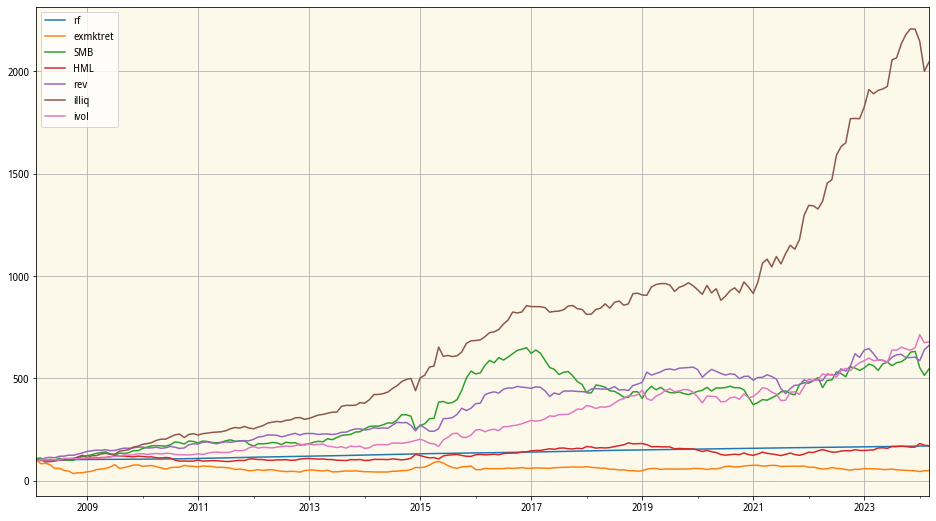

In [174]:
ax = ((factors_df+1).cumprod()*100).plot(grid=True)
ax.set_facecolor("#fcf9eb")
ax.set_xlabel("")
fig = ax.get_figure()
fig.savefig('quant.png',bbox_inches='tight')

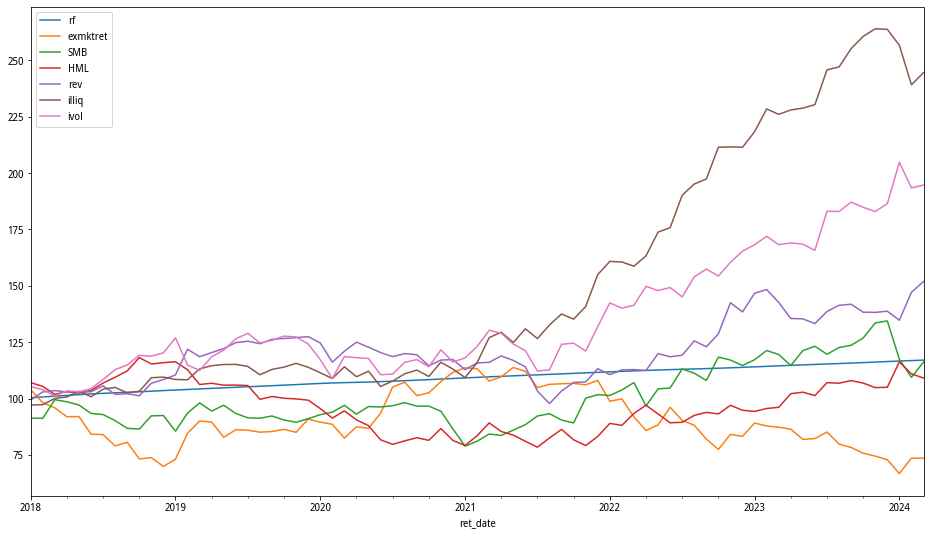

In [175]:
((factors_df['2018':]+1).cumprod()*100).plot()

In [176]:
factors_df.to_pickle('./output_data/factors/factors_all.pkl')

## Output factor exposures

In [177]:
ret_df

secID ret_date  tradeDate       ret        rf     exret  \
0       000001.XSHE  2007-07 2007-06-29  0.316497  0.002481  0.314016   
1       000001.XSHE  2007-08 2007-07-31  0.048855  0.002404  0.046451   
2       000001.XSHE  2007-09 2007-08-31  0.052105  0.002621  0.049484   
3       000001.XSHE  2007-10 2007-09-28  0.201851  0.003095  0.198756   
4       000001.XSHE  2007-11 2007-10-31 -0.249116  0.003780 -0.252896   
5       000001.XSHE  2007-12 2007-11-30  0.069845  0.003011  0.066834   
6       000001.XSHE  2008-01 2007-12-28 -0.137306  0.002949 -0.140255   
7       000001.XSHE  2008-02 2008-01-31 -0.004504  0.002946 -0.007450   
...             ...      ...        ...       ...       ...       ...   
616455  689009.XSHG  2023-10 2023-09-28 -0.058570  0.001890 -0.060460   
616456  689009.XSHG  2023-11 2023-10-31  0.009454  0.001914  0.007540   
616457  689009.XSHG  2023-12 2023-11-30 -0.103927  0.002068 -0.105996   
616458  689009.XSHG  2024-01 2023-12-29 -0.213082  0.001902 -0.214983   
616459  689009.XSHG  2024-02 2024-01-31  0.298201  0.001749  0.296451   
616460  689009.XSHG  2024-03 2024-02-29 -0.011551  0.001783 -0.013334   
616461  689009.XSHG  2024-04 2024-03-29 -0.071786  0.001687 -0.073474   
616462  689009.XSHG      NaT 2024-04-12       NaN       NaN       NaN   

             ym        mktcap       size       rev mom_date       mom    beta  \
0       2007-06  4.266117e+10  24.476555       NaN      NaT       NaN  0.4614   
1       2007-07  5.616330e+10  24.751529  0.314016  2007-06       NaN  0.6423   
2       2007-08  5.890714e+10  24.799228  0.046451  2007-07       NaN  0.7722   
3       2007-09  6.197651e+10  24.850021  0.049484  2007-08       NaN  0.7596   
4       2007-10  7.448652e+10  25.033884  0.198756  2007-09       NaN  0.7988   
5       2007-11  5.593078e+10  24.747381 -0.252896  2007-10       NaN  0.9560   
6       2007-12  6.574629e+10  24.909069  0.066834  2007-11       NaN  0.9468   
7       2008-01  5.850212e+10  24.792329 -0.140255  2007-12       NaN  0.9654   
...         ...           ...        ...       ...      ...       ...     ...   
616455  2023-09  1.785208e+10  23.605386  0.040598  2023-08 -0.127904  0.9152   
616456  2023-10  1.716478e+10  23.566125 -0.060460  2023-09  0.088437  0.9247   
616457  2023-11  1.732706e+10  23.575535  0.007540  2023-10 -0.017675  0.9541   
616458  2023-12  1.552630e+10  23.465801 -0.105996  2023-11  0.085602  1.0448   
616459  2024-01  1.221793e+10  23.226170 -0.214983  2023-12 -0.106357  1.2314   
616460  2024-02  1.586132e+10  23.487149  0.296451  2024-01 -0.292727  1.4905   
616461  2024-03  1.543851e+10  23.460131 -0.013334  2024-02 -0.195005  1.5477   
616462  2024-04  1.433023e+10  23.385637 -0.073474  2024-03 -0.104366     NaN   

              bm     illiq  illiq_12m       vol      ivol  vol_clip  ivol_clip  
0       0.123739       NaN        NaN       NaN       NaN       NaN        NaN  
1       0.093992  0.000040        NaN  0.041604       NaN  0.041604        NaN  
2       0.097085  0.000020        NaN  0.033926       NaN  0.033926        NaN  
3       0.092276  0.000025        NaN  0.023872       NaN  0.023872        NaN  
4       0.083411  0.000030        NaN  0.035921       NaN  0.035921        NaN  
5       0.111084  0.000048        NaN  0.033184       NaN  0.033184        NaN  
6       0.094476  0.000025        NaN  0.026541       NaN  0.026541        NaN  
7       0.109513  0.000039        NaN  0.037722  0.012909  0.037722   0.012909  
...          ...       ...        ...       ...       ...       ...        ...  
616455  0.209367  0.000114   0.000119  0.014750  0.006809  0.014750   0.006809  
616456  0.223899  0.000226   0.000118  0.019076  0.011139  0.019076   0.011139  
616457  0.221803  0.000086   0.000115  0.017594  0.015128  0.017594   0.015128  
616458  0.247525  0.000110   0.000107  0.024634  0.018228  0.024634   0.018228  
616459  0.313607  0.000184   0.000116  0.024607  0.013890  0.024607   0.013890  
616460  0.241569  0.00016

In [178]:
ret_df.to_pickle('./output_data/factor_exposure/all_exposure.pkl')

In [179]:
cols = ['size','bm','rev','illiq','ivol']

In [180]:
ret_df[['secID','tradeDate','rev']].dropna().pivot(index='tradeDate',
                                                columns='secID',values='rev')

secID       000001.XSHE  000002.XSHE  000004.XSHE  000005.XSHE  000006.XSHE  \
tradeDate                                                                     
2007-02-28          NaN    -0.039341          NaN          NaN     0.079198   
2007-03-30          NaN     0.123274          NaN          NaN     0.101648   
2007-04-30          NaN     0.087689          NaN          NaN     0.418516   
2007-05-31          NaN     0.618401          NaN          NaN     0.327713   
2007-06-29          NaN    -0.017483          NaN          NaN    -0.065749   
2007-07-02          NaN          NaN          NaN          NaN          NaN   
2007-07-31     0.314016     0.477643          NaN          NaN     0.282658   
2007-08-31     0.046451     0.191943          NaN          NaN    -0.032089   
...                 ...          ...          ...          ...          ...   
2024-01-31     0.005553    -0.084119    -0.236253    -0.123359    -0.093406   
2024-02-06          NaN          NaN          NaN          NaN          NaN   
2024-02-29     0.117700     0.044084     0.010396     0.030079    -0.028128   
2024-03-01          NaN          NaN          NaN          NaN          NaN   
2024-03-15          NaN          NaN          NaN          NaN          NaN   
2024-03-28          NaN          NaN          NaN          NaN          NaN   
2024-03-29    -0.008393    -0.105369     0.202223    -0.146049    -0.028877   
2024-04-12    -0.045414    -0.212799    -0.177106    -0.001687    -0.070043   

secID       000007.XSHE  000008.XSHE  000009.XSHE  000010.XSHE  000011.XSHE  \
tradeDate                                                                     
2007-02-28     0.293391     0.140721          NaN          NaN          NaN   
2007-03-30     0.318730     0.177471          NaN          NaN          NaN   
2007-04-30     0.204700          NaN          NaN          NaN          NaN   
2007-05-31          NaN          NaN          NaN          NaN          NaN   
2007-06-29          NaN          NaN          NaN          NaN          NaN   
2007-07-02          NaN          NaN          NaN          NaN          NaN   
2007-07-31          NaN          NaN          NaN          NaN          NaN   
2007-08-31          NaN          NaN          NaN          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2024-01-31    -0.084049    -0.099359    -0.081964    -0.228327    -0.031258   
2024-02-06          NaN          NaN          NaN          NaN          NaN   
2024-02-29    -0.111369     0.007642     0.100104    -0.046458    -0.030817   
2024-03-01          NaN          NaN          NaN          NaN          NaN   
2024-03-15          NaN          NaN          NaN          NaN          NaN   
2024-03-28          NaN          NaN          NaN          NaN          NaN   
2024-03-29     0.121332     0.151694    -0.111029     0.002482    -0.014949   
2024-04-12    -0.010632    -0.042002    -0.012066    -0.094892    -0.011400   

secID       ...  688787.XSHG  688788.XSHG  688789.XSHG  688793.XSHG  \
tradeDate   ...                                                       
2007-02-28  ...          NaN          NaN          NaN          NaN   
2007-03-30  ...          NaN          NaN          NaN          NaN   
2007-04-30  ...          NaN          NaN          NaN          NaN   
2007-05-31  ...          NaN          NaN          NaN          NaN   
2007-06-29  ...          NaN          NaN          NaN          NaN   
2007-07-02  ...          NaN          NaN          NaN          NaN   
2007-07-31  ...          NaN          NaN          NaN          NaN   
2007-08-31  ...          NaN          NaN          NaN          NaN   
...         ...          ...          ...          ...          ...   
2024-01-31  ...    -0.266817    -0.287841    -0.205282    -0.162390   
2024-02-06  ...          NaN          NaN          NaN          NaN   
2024-02-29  ...     0.091651     0.001519     0.224533    -0.014839   
20

In [181]:
temp = ret_df[['secID','tradeDate','size']].dropna().pivot(index='tradeDate',
                                                columns='secID',values='size').reset_index()
temp['tradeDate'] = temp['tradeDate'].dt.strftime('%Y/%m/%d')
temp.set_index('tradeDate')

secID       000001.XSHE  000002.XSHE  000004.XSHE  000005.XSHE  000006.XSHE  \
tradeDate                                                                     
2007/02/28          NaN    24.593794          NaN          NaN    21.759995   
2007/03/30          NaN    24.712034          NaN          NaN    21.858822   
2007/04/30          NaN    24.798040          NaN          NaN    22.209934   
2007/05/31          NaN    25.274487          NaN          NaN    22.482926   
2007/06/29    24.476555    25.259434          NaN          NaN    22.417635   
2007/07/02          NaN          NaN          NaN          NaN          NaN   
2007/07/31    24.751529    25.651961          NaN          NaN    22.668582   
2007/08/31    24.799228    25.892469          NaN          NaN    22.638445   
...                 ...          ...          ...          ...          ...   
2024/01/31    25.935897    25.258872    21.167732    20.717720    22.451277   
2024/02/06          NaN          NaN          NaN          NaN          NaN   
2024/02/29    26.048735    25.303686    21.179805    20.749137    22.424544   
2024/03/01          NaN          NaN          NaN          NaN          NaN   
2024/03/15          NaN          NaN          NaN          NaN          NaN   
2024/03/28          NaN          NaN          NaN          NaN          NaN   
2024/03/29    26.042103    25.194361    21.365454    20.593266    22.397077   
2024/04/12    25.997392    24.957231    21.172579    20.593266    22.326274   

secID       000007.XSHE  000008.XSHE  000009.XSHE  000010.XSHE  000011.XSHE  \
tradeDate                                                                     
2007/02/28    19.937819    19.417744          NaN          NaN          NaN   
2007/03/30    20.216174    19.582993          NaN          NaN          NaN   
2007/04/30    20.404169          NaN          NaN          NaN          NaN   
2007/05/31          NaN          NaN          NaN          NaN          NaN   
2007/06/29          NaN          NaN          NaN          NaN          NaN   
2007/07/02          NaN          NaN          NaN          NaN          NaN   
2007/07/31          NaN          NaN          NaN          NaN          NaN   
2007/08/31          NaN          NaN          NaN          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2024/01/31    21.046072    22.467692    24.039466    20.973668    22.233478   
2024/02/06          NaN          NaN          NaN          NaN          NaN   
2024/02/29    20.929965    22.477038    24.136458    20.927922    22.203977   
2024/03/01          NaN          NaN          NaN          NaN          NaN   
2024/03/15          NaN          NaN          NaN          NaN          NaN   
2024/03/28          NaN          NaN          NaN          NaN          NaN   
2024/03/29    21.046072    22.619829    24.020774    20.932168    22.190716   
2024/04/12    21.037083    22.578671    24.010342    20.834312    22.180960   

secID       ...  688787.XSHG  688788.XSHG  688789.XSHG  688793.XSHG  \
tradeDate   ...                                                       
2007/02/28  ...          NaN          NaN          NaN          NaN   
2007/03/30  ...          NaN          NaN          NaN          NaN   
2007/04/30  ...          NaN          NaN          NaN          NaN   
2007/05/31  ...          NaN          NaN          NaN          NaN   
2007/06/29  ...          NaN          NaN          NaN          NaN   
2007/07/02  ...          NaN          NaN          NaN          NaN   
2007/07/31  ...          NaN          NaN          NaN          NaN   
2007/08/31  ...          NaN          NaN          NaN          NaN   
...         ...          ...          ...          ...          ...   
2024/01/31  ...    21.523410    21.460335    22.453908    20.657303   
2024/02/06  ...          NaN          NaN          NaN          NaN   
2024/02/29  ...    21.612699    21.463588    22.657897    20.644119   
20

In [182]:
for c in cols:
    temp = ret_df[['secID','tradeDate',c]].dropna().pivot(index='tradeDate',columns='secID',values=c)
    temp.reset_index(inplace=True)
    temp['tradeDate'] = temp['tradeDate'].dt.strftime('%Y/%m/%d')
    temp.set_index('tradeDate',inplace=True)
    temp.to_csv(f'./output_data/factor_exposure/{c}_exposure.csv')

## Long-only ivol factor

In [183]:
factors_daily = pd.read_pickle('./output_data/factors/factors_daily_long_only.pkl')
illiq_daily = daily_factor(ret_df, stock_df=stk_df,sort1='illiq',long_only=True)
illiq_daily.name = 'illiq_long'
factors_daily = pd.merge(factors_daily, illiq_daily, on='tradeDate')

In [184]:
reg_df = pd.merge(stk_df[['secID','tradeDate','ret_daily']],factors_daily,
                  on=['tradeDate'])
reg_df.sort_values(['secID','tradeDate'],inplace=True)
reg_df['exret'] = reg_df['ret_daily'] - reg_df['rf']
reg_df['ym'] = reg_df['tradeDate'].dt.to_period('M')

In [185]:
reg_df.set_index('ym',inplace=True)

In [186]:
reg_df

secID  tradeDate  ret_daily        rf  exmktret  size_long  \
ym                                                                          
2007-06  000001.XSHE 2007-06-20   0.197544  0.000073 -0.024256  -0.027120   
2007-06  000001.XSHE 2007-06-21   0.100033  0.000064  0.005827  -0.004360   
2007-06  000001.XSHE 2007-06-22   0.031769  0.000058 -0.040473  -0.060460   
2007-06  000001.XSHE 2007-06-25  -0.005650  0.000052 -0.048566  -0.069969   
2007-06  000001.XSHE 2007-06-26   0.000000  0.000049  0.014660   0.017840   
2007-06  000001.XSHE 2007-06-27  -0.084659  0.000047  0.027391   0.025536   
2007-06  000001.XSHE 2007-06-28  -0.064557  0.000046 -0.050035  -0.071769   
2007-06  000001.XSHE 2007-06-29  -0.086928  0.000049 -0.029572  -0.049110   
...              ...        ...        ...       ...       ...        ...   
2024-04  689009.XSHG 2024-04-01   0.036728  0.000047  0.017766   0.023897   
2024-04  689009.XSHG 2024-04-02  -0.021900  0.000047 -0.004091   0.000343   
2024-04  689009.XSHG 2024-04-03  -0.034574  0.000046 -0.003030  -0.009897   
2024-04  689009.XSHG 2024-04-08  -0.062074  0.000047 -0.010232  -0.028268   
2024-04  689009.XSHG 2024-04-09   0.020727  0.000047  0.001500   0.017553   
2024-04  689009.XSHG 2024-04-10  -0.017813  0.000047 -0.009355  -0.023923   
2024-04  689009.XSHG 2024-04-11  -0.008705  0.000047  0.001149   0.000954   
2024-04  689009.XSHG 2024-04-12   0.017197  0.000047 -0.007251  -0.008053   

          bm_long  mom_long  rev_long  illiq_long     exret  
ym                                                           
2007-06 -0.025430       NaN -0.024854   -0.025328  0.197470  
2007-06  0.000312       NaN  0.001203   -0.010721  0.099969  
2007-06 -0.059817       NaN -0.057332   -0.052408  0.031711  
2007-06 -0.069842       NaN -0.064464   -0.055035 -0.005702  
2007-06  0.025272       NaN  0.021764    0.019832 -0.000049  
2007-06  0.022837       NaN  0.025378    0.026533 -0.084706  
2007-06 -0.061015       NaN -0.060412   -0.059985 -0.064602  
2007-06 -0.038481       NaN -0.044104   -0.043622 -0.086977  
...           ...       ...       ...         ...       ...  
2024-04  0.018484  0.015003  0.023777    0.022968  0.036681  
2024-04  0.006944 -0.003919 -0.006005    0.005331 -0.021947  
2024-04 -0.000831 -0.005276 -0.008295   -0.002178 -0.034620  
2024-04 -0.016334 -0.011751 -0.023685   -0.024951 -0.062121  
2024-04  0.009110  0.001992  0.014453    0.016865  0.020680  
2024-04 -0.013312 -0.014439 -0.019970   -0.020832 -0.017860  
2024-04  0.003150  0.002058  0.000186    0.000557 -0.008752  
2024-04 -0.008132 -0.004441 -0.010733   -0.004622  0.017150  

[12353873 rows x 11 columns]

In [187]:
gc.collect()

1614

In [188]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

               stk_unfilled_df:  2.8 GiB
                          _119:  1.8 GiB
                          _121:  1.8 GiB
                          _144:  1.8 GiB
                            __:  1.8 GiB
                        reg_df:  1.8 GiB
                          _186:  1.8 GiB
                        stk_df:  1.7 GiB
                          _102:  1.7 GiB
                       beta_df:  1.1 GiB


In [189]:
del stk_unfilled_df, beta_df

In [190]:
del _119

In [191]:
del _121, _144, __, _186, _102

In [192]:
# %%time
# ivol = reg_df.groupby(['secID']).apply(idiovol_np, factor_cols=['exmktret','size_long','bm_long','mom_long','rev_long','illiq_long'])
# # Takes about 32min 25s to execute

CPU times: user 31min 58s, sys: 24.2 s, total: 32min 22s
Wall time: 32min 22s


In [193]:
# ivol = ivol.reset_index().drop('level_1',axis=1)
# display(ivol)
# ivol.to_pickle('./data/idiovol1m_long_only.pkl')

secID       ym  idiovol1m
0       000001.XSHE  2007-06        NaN
1       000001.XSHE  2007-07        NaN
2       000001.XSHE  2007-08        NaN
3       000001.XSHE  2007-09        NaN
4       000001.XSHE  2007-10        NaN
5       000001.XSHE  2007-11        NaN
6       000001.XSHE  2007-12        NaN
7       000001.XSHE  2008-01   0.013280
...             ...      ...        ...
615244  689009.XSHG  2023-09   0.006531
615245  689009.XSHG  2023-10   0.010385
615246  689009.XSHG  2023-11   0.014611
615247  689009.XSHG  2023-12   0.017238
615248  689009.XSHG  2024-01   0.014305
615249  689009.XSHG  2024-02   0.024220
615250  689009.XSHG  2024-03   0.023787
615251  689009.XSHG  2024-04        NaN

[615252 rows x 3 columns]

In [244]:
vol_df = stk_df.groupby(['secID','ym'])['ret_daily'].std()
vol_df = vol_df.to_frame()
vol_df.columns = ['vol']
vol_df.reset_index(inplace=True)
MIN_NOBS = 15
idx = stk_df.groupby(['secID','ym'],as_index=False)['tradeDate'].count()['tradeDate'] < MIN_NOBS
vol_df.loc[idx, 'vol'] = np.nan

In [245]:
ivol = pd.read_pickle('./data/idiovol1m_long_only.pkl')
vol_df = pd.merge(vol_df,ivol,on=['secID','ym'])
vol_df['vol_clip'] = vol_df['vol'].clip(lower=vol_df['vol'].quantile(0.001),
                                        upper=vol_df['vol'].quantile(0.999))
vol_df['ivol_clip'] = vol_df['idiovol1m'].clip(lower=vol_df['idiovol1m'].quantile(0.001),
                                               upper=vol_df['idiovol1m'].quantile(0.999))
vol_df.rename(columns={'idiovol1m':'ivol'},inplace=True)

In [246]:
try:
    ret_df.drop(['vol','ivol','vol_clip','ivol_clip'],axis=1,inplace=True)
except KeyError:
    pass

In [247]:
ret_df = pd.merge(ret_df,vol_df,
                  on=['secID','ym'])

In [249]:
ret_df

secID ret_date  tradeDate       ret        rf     exret  \
0       000001.XSHE  2007-07 2007-06-29  0.316497  0.002481  0.314016   
1       000001.XSHE  2007-08 2007-07-31  0.048855  0.002404  0.046451   
2       000001.XSHE  2007-09 2007-08-31  0.052105  0.002621  0.049484   
3       000001.XSHE  2007-10 2007-09-28  0.201851  0.003095  0.198756   
4       000001.XSHE  2007-11 2007-10-31 -0.249116  0.003780 -0.252896   
5       000001.XSHE  2007-12 2007-11-30  0.069845  0.003011  0.066834   
6       000001.XSHE  2008-01 2007-12-28 -0.137306  0.002949 -0.140255   
7       000001.XSHE  2008-02 2008-01-31 -0.004504  0.002946 -0.007450   
...             ...      ...        ...       ...       ...       ...   
615244  689009.XSHG  2023-10 2023-09-28 -0.058570  0.001890 -0.060460   
615245  689009.XSHG  2023-11 2023-10-31  0.009454  0.001914  0.007540   
615246  689009.XSHG  2023-12 2023-11-30 -0.103927  0.002068 -0.105996   
615247  689009.XSHG  2024-01 2023-12-29 -0.213082  0.001902 -0.214983   
615248  689009.XSHG  2024-02 2024-01-31  0.298201  0.001749  0.296451   
615249  689009.XSHG  2024-03 2024-02-29 -0.011551  0.001783 -0.013334   
615250  689009.XSHG  2024-04 2024-03-29 -0.071786  0.001687 -0.073474   
615251  689009.XSHG      NaT 2024-04-12       NaN       NaN       NaN   

             ym        mktcap       size       rev mom_date       mom    beta  \
0       2007-06  4.266117e+10  24.476555       NaN      NaT       NaN  0.4614   
1       2007-07  5.616330e+10  24.751529  0.314016  2007-06       NaN  0.6423   
2       2007-08  5.890714e+10  24.799228  0.046451  2007-07       NaN  0.7722   
3       2007-09  6.197651e+10  24.850021  0.049484  2007-08       NaN  0.7596   
4       2007-10  7.448652e+10  25.033884  0.198756  2007-09       NaN  0.7988   
5       2007-11  5.593078e+10  24.747381 -0.252896  2007-10       NaN  0.9560   
6       2007-12  6.574629e+10  24.909069  0.066834  2007-11       NaN  0.9468   
7       2008-01  5.850212e+10  24.792329 -0.140255  2007-12       NaN  0.9654   
...         ...           ...        ...       ...      ...       ...     ...   
615244  2023-09  1.785208e+10  23.605386  0.040598  2023-08 -0.127904  0.9152   
615245  2023-10  1.716478e+10  23.566125 -0.060460  2023-09  0.088437  0.9247   
615246  2023-11  1.732706e+10  23.575535  0.007540  2023-10 -0.017675  0.9541   
615247  2023-12  1.552630e+10  23.465801 -0.105996  2023-11  0.085602  1.0448   
615248  2024-01  1.221793e+10  23.226170 -0.214983  2023-12 -0.106357  1.2314   
615249  2024-02  1.586132e+10  23.487149  0.296451  2024-01 -0.292727  1.4905   
615250  2024-03  1.543851e+10  23.460131 -0.013334  2024-02 -0.195005  1.5477   
615251  2024-04  1.433023e+10  23.385637 -0.073474  2024-03 -0.104366     NaN   

              bm     illiq  illiq_12m       vol      ivol  vol_clip  ivol_clip  
0       0.123739       NaN        NaN       NaN       NaN       NaN        NaN  
1       0.093992  0.000040        NaN  0.041604       NaN  0.041604        NaN  
2       0.097085  0.000020        NaN  0.033926       NaN  0.033926        NaN  
3       0.092276  0.000025        NaN  0.023872       NaN  0.023872        NaN  
4       0.083411  0.000030        NaN  0.035921       NaN  0.035921        NaN  
5       0.111084  0.000048        NaN  0.033184       NaN  0.033184        NaN  
6       0.094476  0.000025        NaN  0.026541       NaN  0.026541        NaN  
7       0.109513  0.000039        NaN  0.037722  0.013280  0.037722   0.013280  
...          ...       ...        ...       ...       ...       ...        ...  
615244  0.209367  0.000114   0.000119  0.014750  0.006531  0.014750   0.006531  
615245  0.223899  0.000226   0.000118  0.019076  0.010385  0.019076   0.010385  
615246  0.221803  0.000086   0.000115  0.017594  0.014611  0.017594   0.014611  
615247  0.247525  0.000110   0.000107  0.024634  0.017238  0.024634   0.017238  
615248  0.313607  0.000184   0.000116  0.024607  0.014305  0.024607   0.014305  
615249  0.241569  0.00016

In [229]:
# ivol.loc[ivol['ym']=='2015-09'].describe()

# temp = ivol.loc[ivol['ym']=='2015-09']

# temp.loc[temp['idiovol1m'].idxmin()]

# temp['secID']

# temp.loc[temp['idiovol1m'] <= temp['idiovol1m'].quantile(0.11)]

# ret_df.loc[ret_df['ret_date']=='2015-10']

# q = dict()
# keys = ['q'+str(i) for i in range(1, 10)]
# values = np.arange(0.1, 1.0, 0.1)
# q.update(zip(keys,values))

# quantile_df = pd.DataFrame()
# for key, value in q.items():
#     quantile_df[key] = ret_df.groupby(['ym'])['ivol'].quantile(value)

# df_q = pd.merge(ret_df, quantile_df, on='ym')

# portfolios = dict()
# drop_cols = [col for col in df_q.columns if col[0]=='q']

# portfolios['p1'] = df_q.loc[df_q['ivol'] <= df_q['q1']].copy().drop(drop_cols, axis=1)
# for i in range(2,10):
#     idx = (df_q[f'q{i-1}'] <= df_q['ivol']) & (df_q['ivol'] <= df_q[f'q{i}'])
#     portfolios[f'p{i}'] = df_q.loc[idx].copy().drop(drop_cols, axis=1)
# portfolios['p10'] = df_q.loc[df_q['ivol'] >= df_q['q9']].copy().drop(drop_cols, axis=1)

# pf_n_stks.loc[pd.Period('2015-08'):pd.Period('2015-12')]

# ret_df.loc[ret_df['ym']=='2015-10']

# df_q.loc[df_q['ret_date']=='2015-10']

# pf_n_stks = pd.DataFrame()
# for key, value in portfolios.items():
#     pf_n_stks[key] = portfolios[key].groupby('ret_date')['secID'].nunique()

# display(pf_n_stks)

# pf_n_stks.plot()

# portfolios['p1'].loc[portfolios['p1']['ret_date']=='2015-10']

# def single_sort(df, sort):
#     q = dict()
#     keys = ['q'+str(i) for i in range(1, 10)]
#     values = np.arange(0.1, 1.0, 0.1)
#     q.update(zip(keys,values))

#     quantile_df = pd.DataFrame()
#     for key, value in q.items():
#         quantile_df[key] = df.groupby(['ym'])[sort].quantile(value)

#     df_q = pd.merge(df, quantile_df, on='ym')

#     portfolios = dict()
#     drop_cols = [col for col in df_q.columns if col[0]=='q']

#     portfolios['p1'] = df_q.loc[df_q[sort] <= df_q['q1']].copy().drop(drop_cols, axis=1)
#     for i in range(2,10):
#         idx = (df_q[f'q{i-1}'] <= df_q[sort]) & (df_q[sort] <= df_q[f'q{i}'])
#         portfolios[f'p{i}'] = df_q.loc[idx].copy().drop(drop_cols, axis=1)
#     portfolios['p10'] = df_q.loc[df_q[sort] >= df_q['q9']].copy().drop(drop_cols, axis=1)

#     portfolios_crs_mean = dict()
#     for k in portfolios.keys():
#         portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

#     mean_values = {}
#     t_values = {}
#     for k in portfolios_crs_mean.keys():
#         y = portfolios_crs_mean[k]
#         const = np.full(shape=len(y),fill_value=1)
#         reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
#         mean_values[k] = reg.params[0]
#         t_values[k] = reg.tvalues[0]
#     # Portfolio 10-1
#     y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
#     const = np.full(shape=len(y), fill_value=1)
#     reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
#     mean_values['p10-p1'] = reg.params[0]
#     t_values['p10-p1'] = reg.tvalues[0]
#     print(y.loc[y.isna()])
# #     print(portfolios_crs_mean['p10'].loc[portfolios_crs_mean['p10'].isna()])
# #     print(portfolios_crs_mean['p1'].loc[portfolios_crs_mean['p1'].isna()])
#     print(portfolios_crs_mean['p10'].loc[pd.Period('2015-10')])
# #     print(portfolios_crs_mean['p1'].loc[pd.Period('2015-10')])
#     print(portfolios_crs_mean['p1'].loc[pd.Period('2015-09'):pd.Period('2015-12')])
    
#     display(pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
#                  columns=mean_values.keys()))

In [274]:
single_sort(ret_df, 'ivol_clip')

ret_date
2015-10   NaN
Freq: M, Name: exret, dtype: float64
0.23667685225012972
ret_date
2015-09   -0.082284
2015-11    0.095051
2015-12    0.120059
Freq: M, Name: exret, dtype: float64


p1        p2        p3        p4        p5        p6        p7  \
mean     0.011909  0.011118  0.011484  0.010415  0.010390  0.008203  0.005865   
t-value  1.660988  1.692179  1.716564  1.583204  1.556779  1.235654  0.902228   

              p8        p9       p10  p10-p1  
mean     0.00393  0.000137 -0.007872     NaN  
t-value  0.57827  0.020389 -1.108273     NaN

In [275]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)

# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.073983  0.000538 -0.002904  0.001926  0.001408 -0.027288   
t_values   2.262797  0.134106 -2.234279  0.477725  0.513614 -3.441268   

             illiq  ivol_clip  
ret_mean  9.890651  -0.699331  
t_values  5.070504 -10.881053

In [276]:
ivol_factor = factor(ret_df, sort1='ivol',long_high=False,long_only=True)

In [277]:
factors_long_df = pd.merge(factors_long_df,ivol_factor,on='ret_date',how='left')

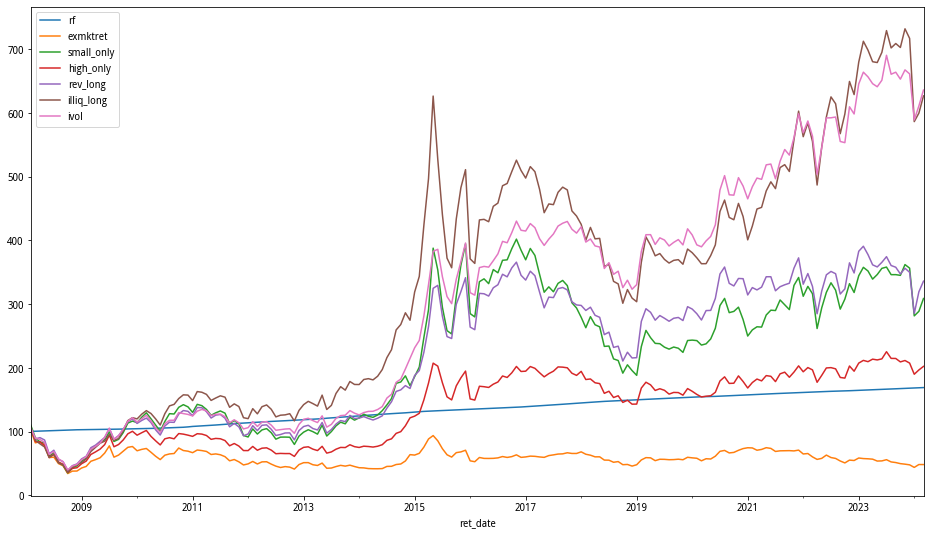

In [278]:
((factors_long_df+1).cumprod()*100).plot()

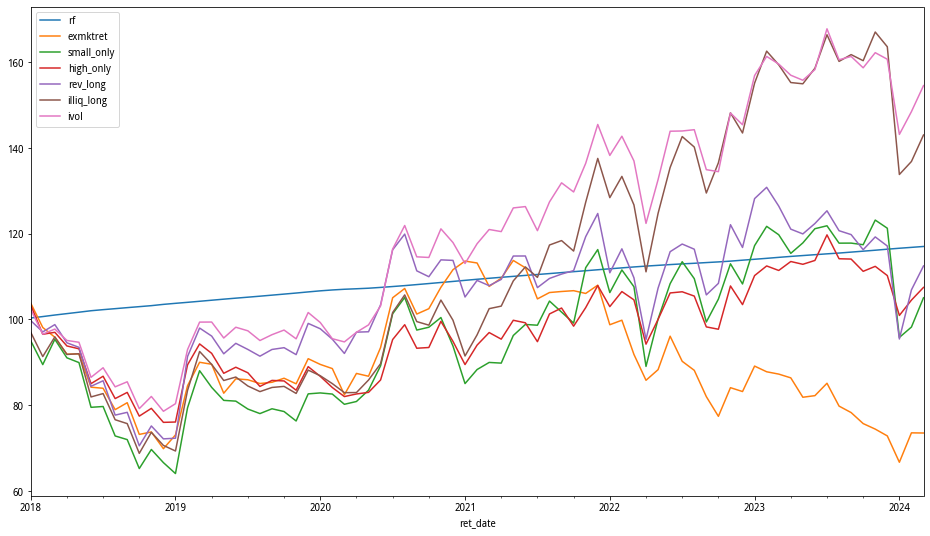

In [279]:
((factors_long_df['2018':]+1).cumprod()*100).plot()

In [280]:
factors_long_df.rename(columns={'ivol':'ivol_long'},inplace=True)

In [281]:
factors_long_df

rf  exmktret  small_only  high_only  rev_long  illiq_long  \
ret_date                                                                    
2008-02   0.002946  0.024010    0.103117   0.059319  0.061681    0.054128   
2008-03   0.002746 -0.195480   -0.180562  -0.202495 -0.166628   -0.180816   
2008-04   0.002862  0.022519   -0.073326  -0.010688  0.023537   -0.063553   
2008-05   0.002953 -0.080798   -0.020022  -0.056407 -0.041286   -0.061992   
2008-06   0.003113 -0.236014   -0.257252  -0.239010 -0.249574   -0.218804   
2008-07   0.002806  0.014972    0.108774   0.072304  0.086499    0.084925   
2008-08   0.002681 -0.170063   -0.232768  -0.187431 -0.203066   -0.206455   
2008-09   0.002889 -0.067913   -0.089285  -0.068049 -0.063174   -0.065761   
...            ...       ...         ...        ...       ...         ...   
2023-08   0.001594 -0.062576   -0.033271  -0.046533 -0.037027   -0.037344   
2023-09   0.001904 -0.018904    0.000098  -0.000625 -0.007526    0.009877   
2023-10   0.001890 -0.032835   -0.003186  -0.025060 -0.029482   -0.008774   
2023-11   0.001914 -0.017006    0.048927   0.010436  0.025713    0.041718   
2023-12   0.002068 -0.021342   -0.015419  -0.019122 -0.017794   -0.020613   
2024-01   0.001902 -0.084298   -0.210021  -0.084317 -0.185138   -0.182079   
2024-02   0.001749  0.102804    0.025233   0.035357  0.120001    0.022659   
2024-03   0.001783 -0.000526    0.069588   0.028328  0.052248    0.045175   

          ivol_long  
ret_date             
2008-02    0.060423  
2008-03   -0.152310  
2008-04   -0.024827  
2008-05   -0.054124  
2008-06   -0.224208  
2008-07    0.067996  
2008-08   -0.165454  
2008-09   -0.080529  
...             ...  
2023-08   -0.043041  
2023-09    0.004817  
2023-10   -0.016420  
2023-11    0.022232  
2023-12   -0.009437  
2024-01   -0.109111  
2024-02    0.037134  
2024-03    0.040866  

[194 rows x 7 columns]

In [282]:
factors_long_df.to_pickle('./output_data/factors/factors_all_long_only.pkl')